# Trabajo Pr√°ctico 1 - Entrenamiento de una red de Hopfield (1982)

## Lorenzo Minervino - Padr√≥n: 107863

## 1 - Entrene una red de Hopfield ‚Äò82 con las im√°genes binarias disponibles en el campus

### Carga y conversi√≥n de im√°genes a formato binario

Se define un conjunto de funciones para cargar las im√°genes `.bmp` desde una carpeta y convertirlas a matrices binarias de `0` y `1`, donde `1` representa p√≠xeles blancos y `0` p√≠xeles negros. Estas matrices representan los patrones que ser√°n almacenados en la red de Hopfield.


In [1]:
from PIL import Image
import os
import numpy as np

def cargar_imagen_en_binario(ruta, invert=False):
    """
    Abre una imagen ya binaria (0 o 255), la convierte a {0,1}.
    - invert: True para 1=negro, False para 1=blanco
    """
    img = Image.open(ruta).convert("L")  
    arr = np.array(img, dtype=np.uint8) 

    binaria = (arr > 0).astype(np.uint8) 
    if invert:
        binaria = 1 - binaria

    h, w = binaria.shape
    print(f"{os.path.basename(ruta)} - tama√±o: {w}x{h}")
    return binaria.tolist()

def cargar_patrones_desde_carpeta(carpeta, invert=False):
    """
    Carga .bmp como patrones binarios {0,1}.
    """
    archivos_bmp = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(".bmp")])
    patrones = []
    for archivo in archivos_bmp:
        ruta_completa = os.path.join(carpeta, archivo)
        patron = cargar_imagen_en_binario(ruta_completa, invert=invert)
        patrones.append(patron)

    if patrones:
        print(f"Se cargaron {len(patrones)} patrones de {len(patrones[0])} filas y {len(patrones[0][0])} columnas cada uno.")
    else:
        print("No se encontraron archivos .bmp en la carpeta.")
    return patrones


### Vectorizaci√≥n y normalizaci√≥n de patrones

En esta etapa se toma cada imagen cargada como una matriz binaria (valores `0` y `1`) y se convierte en un vector unidimensional con valores `-1` y `1`. Esta transformaci√≥n es necesaria porque la red de Hopfield representa cada patr√≥n como un vector de activaciones, donde los valores deben estar centrados en torno al cero para cumplir con los fundamentos del modelo.

Primero, cada valor `0` se transforma en `-1`, y cada `1` se mantiene. Luego, la matriz bidimensional de la imagen se aplana en un solo vector, lo que permite operar con productos exteriores y aplicar din√°micas de red en forma vectorial.

In [2]:
import numpy as np

import numpy as np

def centrar_y_vectorizar_patrones(patrones, invert=False):
    """
    Convierte patrones binarios {0,1} (P,h,w) en vectores {-1,+1} (P,N)
    """
    arr = np.asarray(patrones)
    if arr.size == 0:
        print("Tengo 0 patrones vectorizados de 0 elementos cada uno.")
        return arr.reshape(0, 0).astype(np.int8)

    if arr.ndim == 2: 
        arr = arr[None, ...]

    if invert:
        arr = 1 - arr

    X = arr.reshape(arr.shape[0], -1) 
    Xpm1 = (X * 2 - 1).astype(np.int8) 
    return Xpm1


carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)
patrones_originales = patrones  
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones) 

print("Tengo " + str(len(patrones_vectorizados)) +
      " patrones vectorizados de " + str(len(patrones_vectorizados[0])) +
      " elementos cada uno.")


panda.bmp - tama√±o: 50x50
perro.bmp - tama√±o: 50x50
v.bmp - tama√±o: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
Tengo 3 patrones vectorizados de 2500 elementos cada uno.


### Inicializaci√≥n de la matriz de pesos

Antes de entrenar la red de Hopfield, se debe crear la matriz de pesos sin√°pticos `W`, que define las conexiones entre neuronas. Esta matriz es cuadrada y tiene dimensiones `N √ó N`, donde `N` es la cantidad total de p√≠xeles (o neuronas) por patr√≥n.

Inicialmente, todos los pesos se establecen en cero, y luego se actualizar√°n mediante la regla de Hebb durante el entrenamiento. Esta matriz almacena el conocimiento aprendido por la red.


In [3]:

def inicializar_matriz_pesos(dimension, dtype=np.float32):
    """
    Inicializa una matriz cuadrada de pesos de tama√±o NxN con ceros.
    """
    return np.zeros((dimension, dimension), dtype=dtype)

ancho = 50
alto = 50
dimension = ancho * alto  # 2500

pesos = inicializar_matriz_pesos(dimension)
print(f"mis pesos tienen la dimensi√≥n: {len(pesos)}x{len(pesos[0])}")

mis pesos tienen la dimensi√≥n: 2500x2500


### Entrenamiento de la red de Hopfield

La red de Hopfield se entrena utilizando la **regla de Hebb**, una regla de aprendizaje no supervisado que refuerza las conexiones entre neuronas que se activan simult√°neamente. En esta implementaci√≥n, se recorren todos los patrones vectorizados y se calcula la **suma de los productos exteriores** de cada patr√≥n consigo mismo.

El resultado es una matriz de pesos sin√°pticos que almacena la informaci√≥n de los patrones aprendidos. Finalmente, se eliminan las autoconexiones (valores en la diagonal) ya que una neurona no debe influenciarse a s√≠ misma.

In [4]:
import numpy as np

def entrenar_red_hopfield(patrones_vectorizados, norm='N'):
    """
    Entrena Hopfield con patrones en {-1, +1} (acepta tambi√©n {0,1} y los convierte).
    Retorna W (N, N) float32, diagonal = 0.
    
    norm: 'N' -> divide por N (cl√°sico Hopfield)
          'P' -> divide por P (otra alternativa)
    """
    X = np.asarray(patrones_vectorizados)
    if X.ndim == 1:
        X = X[None, :]

    u = np.unique(X)
    uset = set(u.tolist())
    if uset.issubset({0, 1}):
        X = (X.astype(np.int16) * 2 - 1).astype(np.int8)
    elif not uset.issubset({-1, 1}):
        X = np.where(X > 0, 1, -1).astype(np.int8)

    X = X.astype(np.float32, copy=False)
    P, N = X.shape

    W = X.T @ X
    if norm == 'N':
        W /= float(N)
    elif norm == 'P':
        W /= float(P)
    else:
        raise ValueError("norm debe ser 'N' o 'P'.")

    np.fill_diagonal(W, 0.0)
    return W

pesos = entrenar_red_hopfield(patrones_vectorizados, norm='N') 
print(f"Matriz de pesos entrenada con tama√±o: {len(pesos)}x{len(pesos[0])}")


Matriz de pesos entrenada con tama√±o: 2500x2500


In [5]:
def recuperar_patron(patron_inicial, pesos, max_iter=100, rng=None, tolerancia=0):
    """
    Recupera un patr√≥n aplicando actualizaci√≥n as√≠ncrona hasta converger.
    
    Par√°metros
    ----------
    patron_inicial : array-like (N,)
        Estado inicial en {-1, +1}.
    pesos : np.ndarray (N, N)
        Matriz de pesos (float), idealmente con diagonal en 0.
    max_iter : int
        M√°ximo de barridos as√≠ncronos completos.
    rng : np.random.Generator | None
        Generador para reproducibilidad. Si None, se crea uno por defecto.
    tolerancia : float
        Tolerancia de convergencia; si no hay cambios significativos en el patr√≥n, se considera convergido.
    """
    W = np.asarray(pesos)
    estado = np.asarray(patron_inicial, dtype=np.int8).copy()
    N = estado.size
    if rng is None:
        rng = np.random.default_rng()

    for _ in range(max_iter):
        cambios = 0
        for i in rng.permutation(N):  # orden aleatorio en cada barrido
            h = W[i].dot(estado)
            nuevo = 1 if h >= 0 else -1
            if estado[i] != nuevo:
                estado[i] = nuevo
                cambios += 1
        
        # Si no hubo cambios o los cambios son menores a la tolerancia, consideramos que convergi√≥
        if cambios <= tolerancia:
            break

    return estado


Representaci√≥n visual para comparar el patr√≥n de entrada y el que recuper√≥

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def mostrar_comparacion_patron(original, recuperado, ancho, alto, indice=0):
    ori = np.asarray(original).reshape(alto, ancho)
    rec = np.asarray(recuperado).reshape(alto, ancho)
    
    if ori.min() < 0 or rec.min() < 0:
        ori_show = (ori + 1) / 2.0
        rec_show = (rec + 1) / 2.0
    else:
        ori_show, rec_show = ori, rec

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(ori_show, cmap='gray', vmin=0, vmax=1)
    axs[0].set_title(f"Original")
    axs[0].axis('off')

    axs[1].imshow(rec_show, cmap='gray', vmin=0, vmax=1)
    axs[1].set_title(f"Recuperado")
    axs[1].axis('off')

    plt.suptitle(f"Comparaci√≥n patr√≥n {indice}")
    plt.tight_layout()
    plt.show()


## 1.a - Verifique si la red aprendi√≥ las im√°genes ense√±adas.

### Evaluaci√≥n de recuperaci√≥n sin ruido

En este paso se verifica si la red de Hopfield es capaz de recuperar correctamente los patrones originales que fueron utilizados durante el entrenamiento. Para ello, cada patr√≥n se usa como entrada inicial y se aplica la din√°mica de la red hasta que converge a un estado estable.

Si el estado final es id√©ntico al patr√≥n original, se considera que la recuperaci√≥n fue exitosa. Esto demuestra que la red ha almacenado correctamente los patrones en su memoria asociativa.


El patr√≥n 0 fue recuperado correctamente.


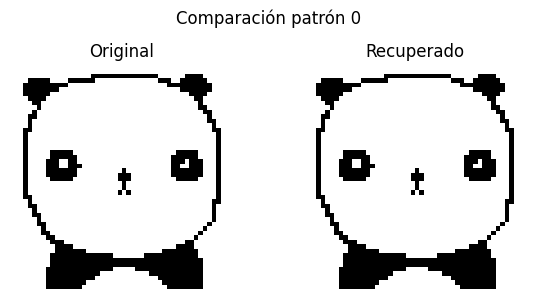

El patr√≥n 1 fue recuperado correctamente.


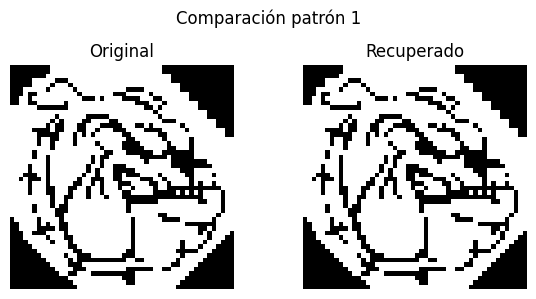

El patr√≥n 2 fue recuperado correctamente.


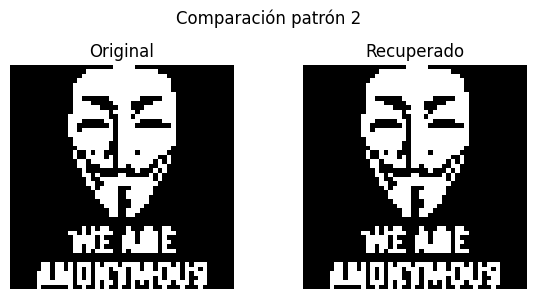

In [7]:
for i in range(len(patrones_vectorizados)):
   
    patron_original = patrones_vectorizados[i];
    estado_convergido = recuperar_patron(patron_original, pesos, max_iter=10000)

    if np.array_equal(estado_convergido, patron_original):
        print(f"El patr√≥n {i} fue recuperado correctamente.")
    else:
        print(f"El patr√≥n {i} NO se recuper√≥ correctamente.")
    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=50, alto=50, indice=i)


### Prueba con im√°genes de 60x45

Se repite el procedimiento anterior utilizando un nuevo conjunto de im√°genes de tama√±o `60x45`. Se cargan, vectorizan y entrenan en la red de Hopfield. Luego, se verifica si la red es capaz de recuperar correctamente los patrones a partir de s√≠ mismos.

Cada comparaci√≥n muestra el patr√≥n original y su versi√≥n recuperada tras aplicar la din√°mica de la red. Esto permite verificar que el modelo puede escalar y seguir funcionando correctamente con im√°genes m√°s grandes.


paloma.bmp - tama√±o: 60x45
quijote.bmp - tama√±o: 60x45
torero.bmp - tama√±o: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.
El patr√≥n 0 fue recuperado correctamente.


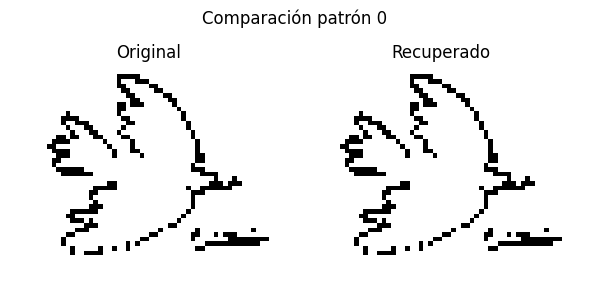

El patr√≥n 1 fue recuperado correctamente.


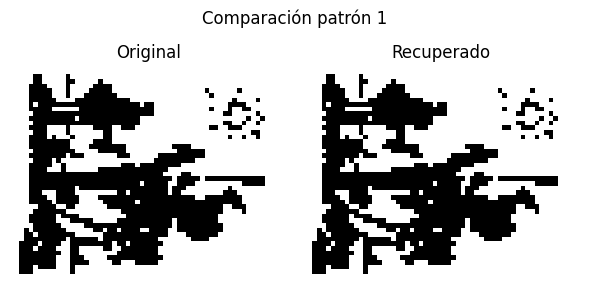

El patr√≥n 2 fue recuperado correctamente.


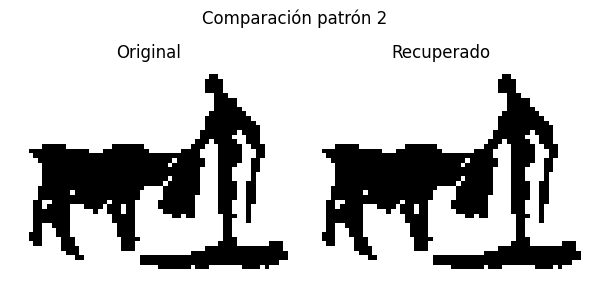

In [8]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes) 
patrones_vectorizados_imagenes_grandes = centrar_y_vectorizar_patrones(patrones)  

ancho = 60
alto = 45
dimension = ancho * alto  

pesos_imagenes_grandes = entrenar_red_hopfield(patrones_vectorizados_imagenes_grandes, norm='N')

for i in range(patrones_vectorizados_imagenes_grandes.shape[0]):
    patron_original = patrones_vectorizados_imagenes_grandes[i]                  # (N,)
    estado_convergido = recuperar_patron(patron_original, pesos_imagenes_grandes, max_iter=10000)

    if np.array_equal(estado_convergido, patron_original):
        print(f"El patr√≥n {i} fue recuperado correctamente.")
    else:
        print(f"El patr√≥n {i} NO se recuper√≥ correctamente.")

    mostrar_comparacion_patron(patron_original, estado_convergido, ancho=ancho, alto=alto, indice=i)


### Conclusi√≥n: entrenamiento con 3 im√°genes

Se entren√≥ la red de Hopfield con un conjunto reducido de 3 im√°genes binarias. La red logr√≥ recuperar todos los patrones correctamente, lo que demuestra que, con un n√∫mero limitado de patrones bien diferenciados, el modelo puede almacenar y recordar eficazmente la informaci√≥n sin interferencia.


## 1.b - Eval√∫e la evoluci√≥n de la red al presentarle versiones alteradas de las im√°genes aprendidas: agregado de ruido, elementos borrados o agregados.

### Agregado de ruido a los patrones

Para evaluar la robustez de la red de Hopfield, se introduce ruido artificial en los patrones antes de presentarlos a la red. La funci√≥n `agregar_ruido` invierte aleatoriamente un porcentaje de los bits del patr√≥n original (valores `-1` o `1`).

Este proceso simula entradas incompletas o corruptas, y permite comprobar si la red es capaz de recuperar el patr√≥n correcto a pesar del ruido. La proporci√≥n de bits alterados se controla mediante el par√°metro `porcentaje_ruido`, que puede variar entre `0.0` (sin ruido) y `1.0` (ruido total).


In [9]:
def agregar_ruido(patron, porcentaje_ruido, rng=None):
    """
    Invierte exactamente floor(n * porcentaje_ruido) bits de un patr√≥n en {-1,+1}.
    
    Par√°metros
    ----------
    patron : array-like (N,) o (h,w)
        El patr√≥n original en {-1, +1} o en {0, 1}.
    porcentaje_ruido : 0..1
        El porcentaje de bits a invertir.
    rng : np.random.Generator opcional para reproducibilidad
        Generador de n√∫meros aleatorios.
    """
    # Asegura que los valores est√©n en {-1, +1}
    x = np.asarray(patron)
    shape = x.shape
    x = x.astype(np.int8, copy=True).ravel()

    # Si los valores no est√°n en {-1, +1}, los normalizamos
    if np.any((x != -1) & (x != 1)):
        x = np.where(x > 0, 1, -1)

    n = x.size
    k = int(n * porcentaje_ruido)
    if k <= 0:
        return x.reshape(shape)

    rng = rng or np.random.default_rng()
    idx = rng.choice(n, size=k, replace=False)  # Selecci√≥n de √≠ndices aleatorios
    x[idx] *= -1  # Invertir los bits seleccionados
    return x.reshape(shape)



In [10]:
def contar_diferencias(p1, p2):
    """
    Cuenta cu√°ntos bits difieren entre dos patrones del mismo tama√±o.
    """
    a = np.asarray(p1)
    b = np.asarray(p2)
    if a.shape != b.shape:
        raise ValueError(f"Formas distintas: {a.shape} vs {b.shape}")
    return int(np.count_nonzero(a != b))


### Evaluaci√≥n de la tolerancia al ruido

En esta secci√≥n se analiza la capacidad de la red de Hopfield para recuperar correctamente los patrones originales a medida que se introduce ruido. Para ello, se prueba con distintos niveles de ruido (de 0% a 100%) invirtiendo aleatoriamente un porcentaje de los bits en cada patr√≥n.

Se calcula el error promedio de recuperaci√≥n (proporci√≥n de bits incorrectos) para cada nivel de ruido. Finalmente, se grafica la precisi√≥n de la red como funci√≥n del ruido, lo cual permite visualizar su comportamiento frente a distorsiones crecientes.

Un buen modelo deber√≠a mantener alta precisi√≥n para bajos niveles de ruido, degrad√°ndose progresivamente a medida que la distorsi√≥n aumenta.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def evaluar_robustez_ruido(patrones_vectorizados, pesos, niveles_ruido=None,
                           max_iter=10000, modo_ruido='exact', rng=None):
    """
    Eval√∫a el desempe√±o de la red de Hopfield ante distintos niveles de ruido.

    Par√°metros
    ----------
    patrones_vectorizados : (P,N) array-like en {-1,+1} (o convertible)
    pesos : (N,N) np.ndarray
    niveles_ruido : iterable de floats en [0,1]; por defecto [0.0, 0.1, ..., 1.0]
    max_iter : int, iteraciones para la convergencia (recuperaci√≥n as√≠ncrona)
    modo_ruido : 'exact' (invierte exactamente floor(p*N) bits por patr√≥n) 
                 'bernoulli' (cada bit se invierte con probabilidad p; m√°s r√°pido)
    rng : np.random.Generator para reproducibilidad

    Retorna
    -------
    niveles_ruido (list[float]), errores_promedio (list[float])
    """
    if niveles_ruido is None:
        niveles_ruido = [i / 10 for i in range(11)]  # 0.0 ... 1.0

    X = np.asarray(patrones_vectorizados)
    if X.ndim == 1:
        X = X[None, :]
    U = set(np.unique(X).tolist())
    if U.issubset({0, 1}):
        X = (X.astype(np.int16)*2 - 1).astype(np.int8)
    elif not U.issubset({-1, 1}):
        X = np.where(X > 0, 1, -1).astype(np.int8)

    P, N = X.shape
    errores_promedio = []
    rng = rng or np.random.default_rng()

    for ruido in niveles_ruido:
        total_errores = 0

        if modo_ruido == 'bernoulli':
            mask = rng.random(size=(P, N)) < float(ruido)
            X_ruidoso = X.copy()
            X_ruidoso[mask] *= -1

            for p in range(P):
                estado_convergido = recuperar_patron(X_ruidoso[p], pesos, max_iter=max_iter)
                total_errores += int(np.count_nonzero(estado_convergido != X[p]))

        else: 
            for p in range(P):
                x_noisy = agregar_ruido(X[p], ruido, rng=rng) 
                estado_convergido = recuperar_patron(x_noisy, pesos, max_iter=max_iter)
                total_errores += int(np.count_nonzero(estado_convergido != X[p]))
                if total_errores == 2500:
                    # Imprimir el patr√≥n recuperado y la comparaci√≥n con el patr√≥n original
                    print("Estado convergido:", estado_convergido)
                    print("Comparaci√≥n con el patr√≥n original:", estado_convergido != X[p])

                    # Contar cu√°ntos 1 y -1 hay en el estado convergido
                    num_1_convergido = np.count_nonzero(estado_convergido == 1)
                    num_neg_1_convergido = np.count_nonzero(estado_convergido == -1)

                    # Contar cu√°ntos 1 y -1 hay en el patr√≥n original
                    num_1_original = np.count_nonzero(X[p] == 1)
                    num_neg_1_original = np.count_nonzero(X[p] == -1)

                    # Imprimir los resultados
                    print(f"Estado convergido tiene {num_1_convergido} veces 1 y {num_neg_1_convergido} veces -1")
                    print(f"Patr√≥n original tiene {num_1_original} veces 1 y {num_neg_1_original} veces -1")
                    
                    # Verificar si el estado convergido es completamente opuesto al patr√≥n original
                    if np.array_equal(estado_convergido, -X[p]):
                        print("El estado convergido es completamente el opuesto al patr√≥n original.")
                    else:
                        print("El estado convergido NO es completamente el opuesto al patr√≥n original.")
            promedio = total_errores / (P * N)
            errores_promedio.append(promedio)
            print(f"Ruido {int(ruido*100)}% ‚Üí Error promedio: {promedio:.4f}")

    return niveles_ruido, errores_promedio


def graficar_precision_vs_ruido(niveles_ruido, errores_promedio):
    """
    Grafica la precisi√≥n de recuperaci√≥n en funci√≥n del nivel de ruido.
    precisi√≥n = 1 - error_promedio
    """
    niveles_ruido = list(niveles_ruido)
    errores_promedio = list(errores_promedio)
    precisiones = [1 - e for e in errores_promedio]

    plt.figure(figsize=(8, 4))
    plt.plot([r * 100 for r in niveles_ruido], precisiones, marker='o', linestyle='-')
    plt.title("Precisi√≥n de recuperaci√≥n vs. nivel de ruido")
    plt.xlabel("Porcentaje de ruido (%)")
    plt.ylabel("Precisi√≥n de recuperaci√≥n")
    plt.ylim(0, 1.05)
    plt.grid(True, alpha=0.3)
    plt.show()


# Imaganes 50x50

Ruido 0% ‚Üí Error promedio: 0.0000
Ruido 10% ‚Üí Error promedio: 0.0000
Ruido 20% ‚Üí Error promedio: 0.0000
Ruido 30% ‚Üí Error promedio: 0.0000
Ruido 40% ‚Üí Error promedio: 0.0000
Ruido 50% ‚Üí Error promedio: 0.4703
Estado convergido: [-1 -1 -1 ... -1 -1 -1]
Comparaci√≥n con el patr√≥n original: [ True  True  True ...  True  True  True]
Estado convergido tiene 490 veces 1 y 2010 veces -1
Patr√≥n original tiene 2010 veces 1 y 490 veces -1
El estado convergido es completamente el opuesto al patr√≥n original.
Ruido 60% ‚Üí Error promedio: 1.0000
Estado convergido: [-1 -1 -1 ... -1 -1 -1]
Comparaci√≥n con el patr√≥n original: [ True  True  True ...  True  True  True]
Estado convergido tiene 490 veces 1 y 2010 veces -1
Patr√≥n original tiene 2010 veces 1 y 490 veces -1
El estado convergido es completamente el opuesto al patr√≥n original.
Ruido 70% ‚Üí Error promedio: 1.0000
Estado convergido: [-1 -1 -1 ... -1 -1 -1]
Comparaci√≥n con el patr√≥n original: [ True  True  True ...  True  Tr

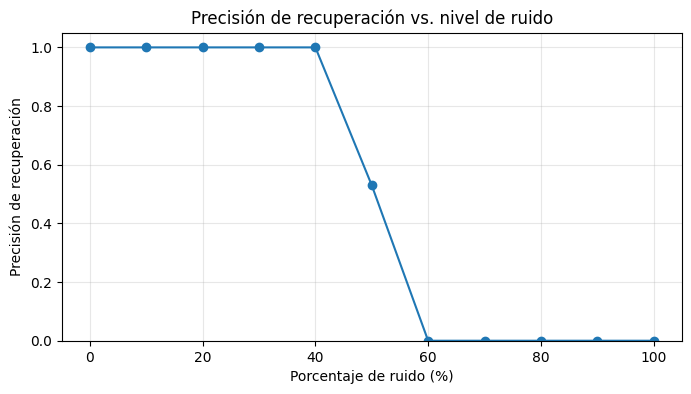

In [12]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados, pesos, max_iter=1000)
graficar_precision_vs_ruido(niveles, errores)


# Imagenes 60x45

Ruido 0% ‚Üí Error promedio: 0.0000
Ruido 10% ‚Üí Error promedio: 0.0000
Ruido 20% ‚Üí Error promedio: 0.0000
Ruido 30% ‚Üí Error promedio: 0.0000
Ruido 40% ‚Üí Error promedio: 0.0000
Ruido 50% ‚Üí Error promedio: 0.4752
Ruido 60% ‚Üí Error promedio: 1.0000
Ruido 70% ‚Üí Error promedio: 1.0000
Ruido 80% ‚Üí Error promedio: 1.0000
Ruido 90% ‚Üí Error promedio: 1.0000
Ruido 100% ‚Üí Error promedio: 1.0000


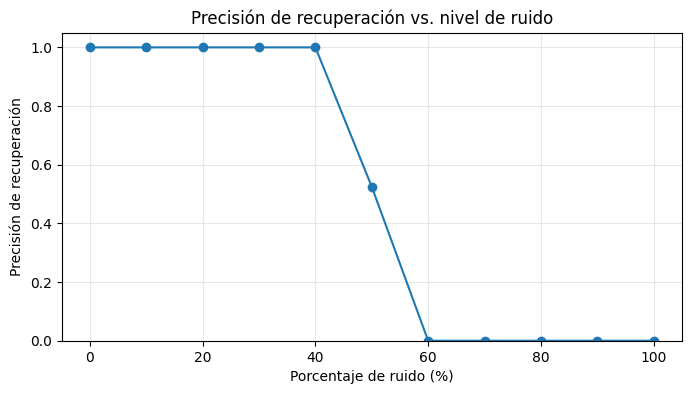

In [13]:
niveles, errores = evaluar_robustez_ruido(patrones_vectorizados_imagenes_grandes, pesos_imagenes_grandes)
graficar_precision_vs_ruido(niveles, errores)


## 1.c - Eval√∫e la existencia de estados espurios en la red: patrones inversos y combinaciones de un n√∫mero impar de patrones. 

### Evaluaci√≥n de estados espurios

En esta celda se prueba la existencia de **estados espurios** en la red de Hopfield entrenada:

- **Patrones invertidos**: se invierte el signo de todos los bits de cada patr√≥n entrenado y se comprueba si el estado permanece estable.
- **Combinaciones impares**: se eval√∫a la estabilidad del estado resultante de aplicar `sign(P0 + P1 + P2)`.

Si estos estados convergen a s√≠ mismos al ser presentados como entrada a la red, se considera que son **estados espurios estables**. Esta es una propiedad conocida de las redes de Hopfield, especialmente cuando se usan m√∫ltiples patrones y hay solapamiento entre ellos.


Por √∫ltimo, se eval√∫a la existencia de estados espurios del tipo **spin-glass**, que son m√≠nimos locales de la energ√≠a que **no se parecen a ning√∫n patr√≥n almacenado** ni a combinaciones de ellos.

Para esto, se generan vectores aleatorios de activaci√≥n (`-1` y `1`) que act√∫an como entradas completamente nuevas. Si la red converge a esos mismos estados sin haberlos aprendido, se considera que son **estados espurios del tipo spin-glass**.

Este fen√≥meno se vuelve m√°s probable a medida que se entrena la red con un mayor n√∫mero de patrones, lo cual genera interferencias y reduce la capacidad efectiva de almacenamiento.

paloma.bmp - tama√±o: 60x45
quijote.bmp - tama√±o: 60x45
torero.bmp - tama√±o: 60x45
Se cargaron 3 patrones de 45 filas y 60 columnas cada uno.

--- Estados inversos ---
Inverso del patr√≥n 0 es un estado espurio estable.


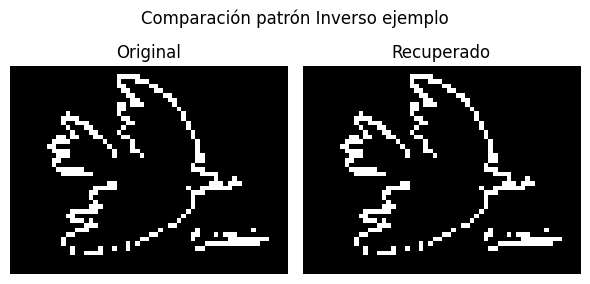

Inverso del patr√≥n 1 es un estado espurio estable.


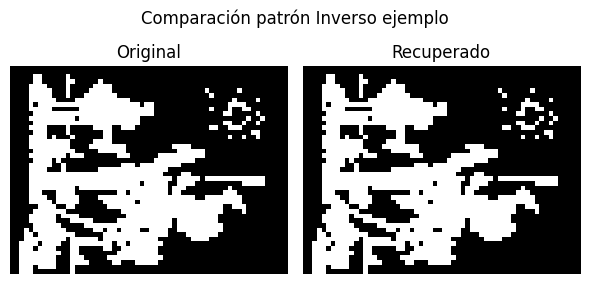

Inverso del patr√≥n 2 es un estado espurio estable.


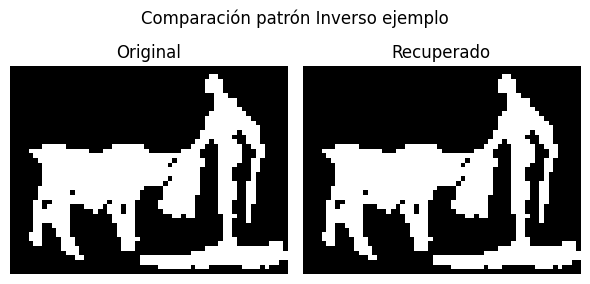


--- Combinaci√≥n impar de 3 patrones: todas las ¬± ---
Combinaci√≥n +P0 +P1 +P2: ESPURIO


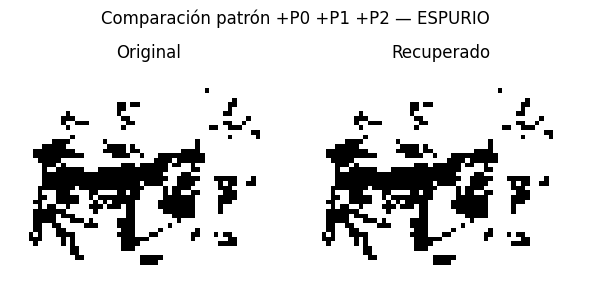

Combinaci√≥n +P0 +P1 -P2: ESPURIO


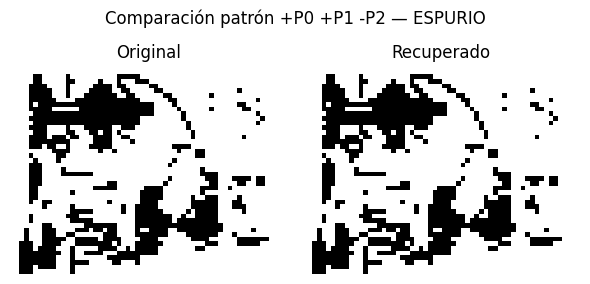

Combinaci√≥n +P0 -P1 +P2: ESPURIO


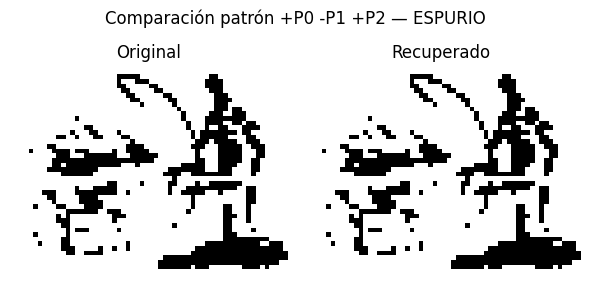

Combinaci√≥n +P0 -P1 -P2: ESPURIO


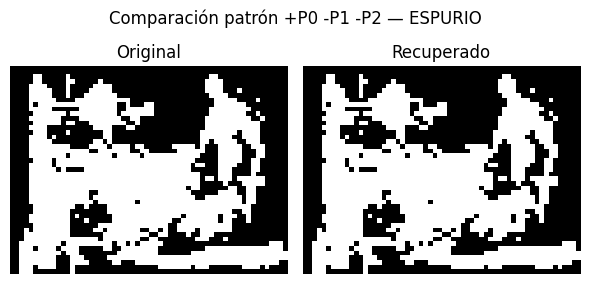

Combinaci√≥n -P0 +P1 +P2: ESPURIO


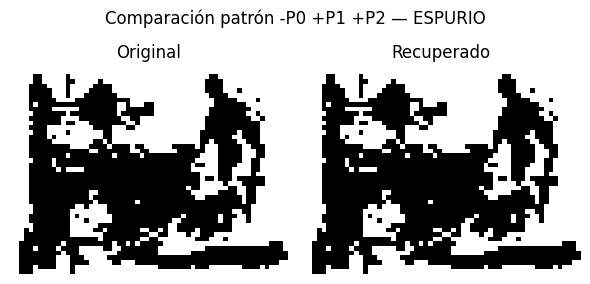

Combinaci√≥n -P0 +P1 -P2: ESPURIO


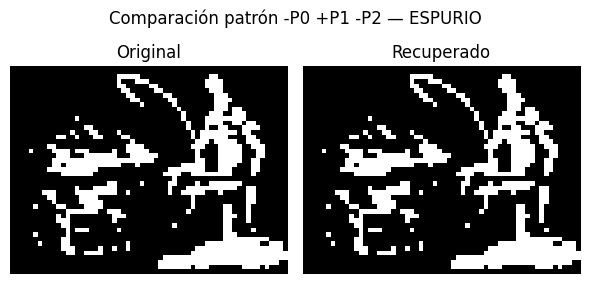

Combinaci√≥n -P0 -P1 +P2: ESPURIO


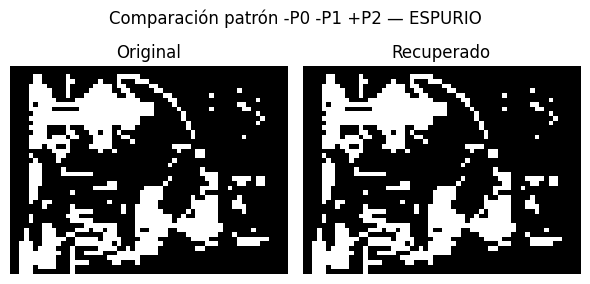

Combinaci√≥n -P0 -P1 -P2: ESPURIO


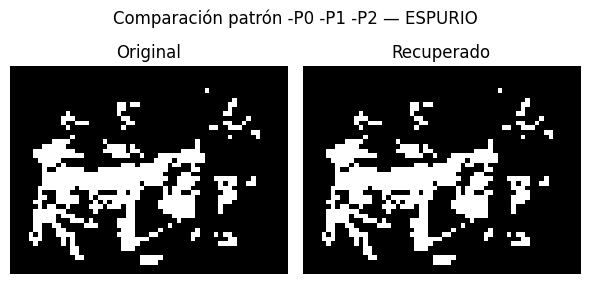


--- Estados tipo spin-glass ---
Estado aleatorio 0 NO es estable.
Estado aleatorio 1 NO es estable.
Estado aleatorio 2 NO es estable.
Estado aleatorio 3 NO es estable.
Estado aleatorio 4 NO es estable.


In [14]:
carpeta_imagenes = "imagenes/60x45"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)            
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)        

ancho, alto = 60, 45
dimension = ancho * alto

pesos = entrenar_red_hopfield(patrones_vectorizados)                

def es_estable(estado, pesos, max_iter=10000):
    """
    Verifica si un estado es un m√≠nimo estable (converge a s√≠ mismo).
    """
    estado = np.asarray(estado, dtype=np.int8).ravel()
    convergido = recuperar_patron(estado, pesos, max_iter=max_iter)
    return np.array_equal(convergido, estado)

# 1) Inversos de cada patr√≥n
print("\n--- Estados inversos ---")
for i in range(patrones_vectorizados.shape[0]):
    patron = patrones_vectorizados[i]
    inverso = (-patron).astype(np.int8, copy=False)
    if es_estable(inverso, pesos):
        print(f"Inverso del patr√≥n {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patr√≥n {i} NO es estable.")
    rec_inv = recuperar_patron(inverso, pesos, max_iter=10000)
    mostrar_comparacion_patron(inverso, rec_inv, ancho, alto, indice="Inverso ejemplo")

# 2) Combinaci√≥n impar de 3 patrones: TODAS las ¬± (sign(P0 ¬± P1 ¬± P2))
print("\n--- Combinaci√≥n impar de 3 patrones: todas las ¬± ---")

if patrones_vectorizados.shape[0] >= 3:
    # Eleg√≠ los 3 que quieras (ac√° uso 0,1,2)
    i0, i1, i2 = 0, 1, 2
    P0 = patrones_vectorizados[i0]
    P1 = patrones_vectorizados[i1]
    P2 = patrones_vectorizados[i2]

    # Todas las combinaciones de signos
    S = np.array([
        [ +1, +1, +1],
        [ +1, +1, -1],
        [ +1, -1, +1],
        [ +1, -1, -1],
        [ -1, +1, +1],
        [ -1, +1, -1],
        [ -1, -1, +1],
        [ -1, -1, -1],
    ], dtype=np.int8)

    def etiqueta_signos(row):
        return " ".join([
            ("+P0" if row[0] == 1 else "-P0"),
            ("+P1" if row[1] == 1 else "-P1"),
            ("+P2" if row[2] == 1 else "-P2"),
        ])

   
    P_stack = np.stack([P0, P1, P2], axis=0).astype(np.int16)   
    comb_sum = S @ P_stack                                     
    combos = np.where(comb_sum >= 0, 1, -1).astype(np.int8)   

    for row, estado in zip(S, combos):
        rec = recuperar_patron(estado, pesos, max_iter=10000)
        estable = np.array_equal(rec, estado)
        print(f"Combinaci√≥n {etiqueta_signos(row)}: {'ESPURIO' if estable else 'NO estable'}")
        mostrar_comparacion_patron(
            estado, rec, ancho, alto,
            indice=f"{etiqueta_signos(row)} ‚Äî {'ESPURIO' if estable else 'NO estable'}"
        )
else:
    print("No hay suficientes patrones para probar combinaci√≥n impar.")

# 3) Estados tipo spin-glass: aleatorios, no relacionados
print("\n--- Estados tipo spin-glass ---")
rng = np.random.default_rng(123)

def generar_estado_aleatorio(n, rng=None):
    rng = rng or np.random.default_rng()
    return np.where(rng.integers(0, 2, size=n, dtype=np.int8)==0, -1, 1).astype(np.int8)

for i in range(5):  # probar 5 estados aleatorios
    estado_random = generar_estado_aleatorio(dimension, rng=rng)
    if es_estable(estado_random, pesos):
        print(f"Estado aleatorio {i} es un m√≠nimo local estable (posible spin-glass).")
    else:
        print(f"Estado aleatorio {i} NO es estable.")


panda.bmp - tama√±o: 50x50
perro.bmp - tama√±o: 50x50
v.bmp - tama√±o: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.

--- Estados inversos ---
Inverso del patr√≥n 0 es un estado espurio estable.


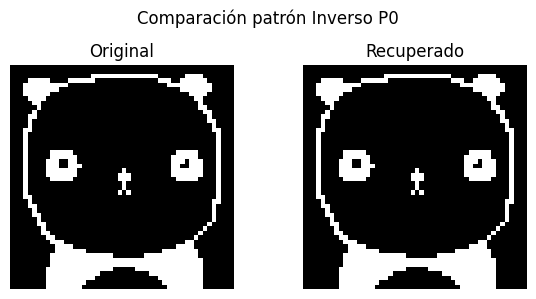

Inverso del patr√≥n 1 es un estado espurio estable.


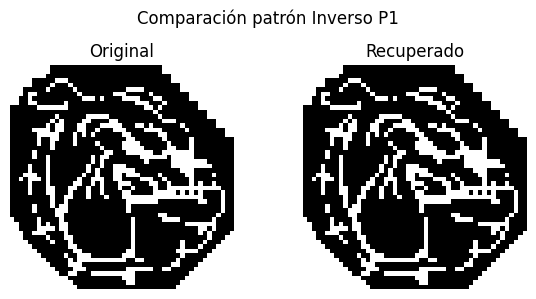

Inverso del patr√≥n 2 es un estado espurio estable.


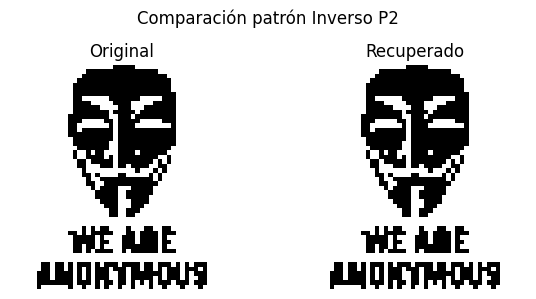


--- Combinaci√≥n impar de 3 patrones: todas las ¬± ---
Combinaci√≥n +P0 +P1 +P2: ESPURIO


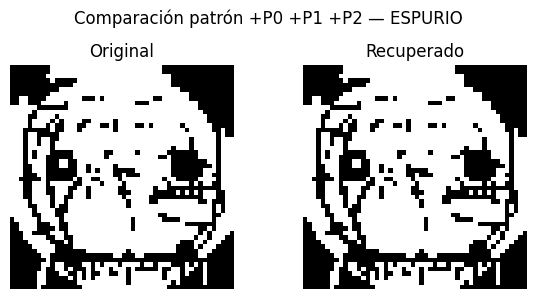

Combinaci√≥n +P0 +P1 -P2: ESPURIO


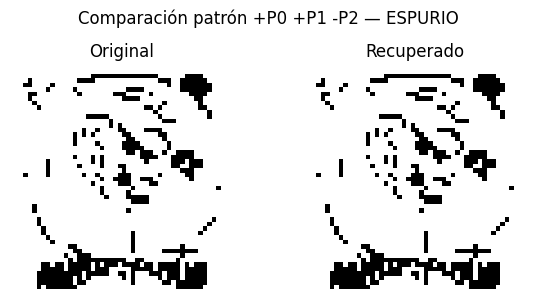

Combinaci√≥n +P0 -P1 +P2: ESPURIO


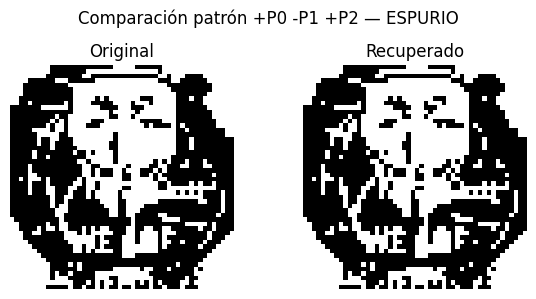

Combinaci√≥n +P0 -P1 -P2: ESPURIO


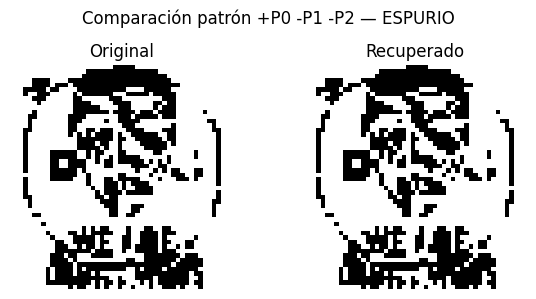

Combinaci√≥n -P0 +P1 +P2: ESPURIO


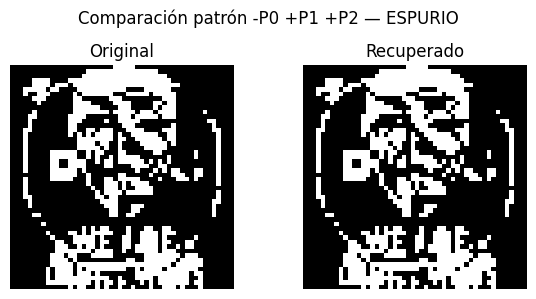

Combinaci√≥n -P0 +P1 -P2: ESPURIO


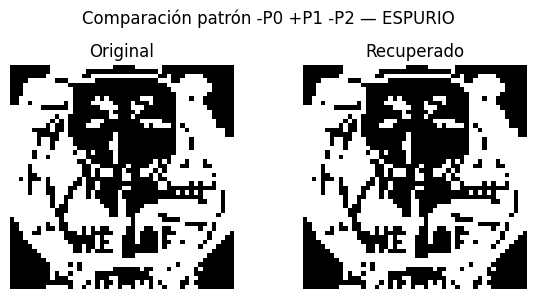

Combinaci√≥n -P0 -P1 +P2: ESPURIO


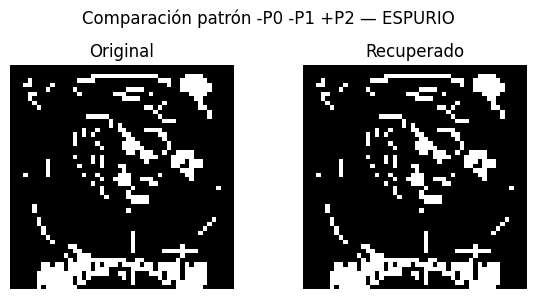

Combinaci√≥n -P0 -P1 -P2: ESPURIO


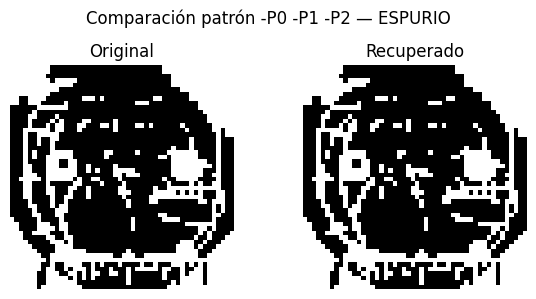


--- Estados tipo spin-glass ---
Estado aleatorio 0 NO es estable.
Estado aleatorio 1 NO es estable.
Estado aleatorio 2 NO es estable.
Estado aleatorio 3 NO es estable.
Estado aleatorio 4 NO es estable.


In [15]:
carpeta_imagenes = "imagenes/50x50"
patrones = cargar_patrones_desde_carpeta(carpeta_imagenes)             
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones)       

ancho, alto = 50, 50
dimension = ancho * alto

# Entrenar la red
pesos = entrenar_red_hopfield(patrones_vectorizados)                   

# ---------- ESTADOS ESPURIOS ----------

# 1) Inversos de cada patr√≥n
print("\n--- Estados inversos ---")
for i in range(patrones_vectorizados.shape[0]):
    patron = patrones_vectorizados[i]
    inverso = (-patron).astype(np.int8, copy=False)
    if es_estable(inverso, pesos):
        print(f"Inverso del patr√≥n {i} es un estado espurio estable.")
    else:
        print(f"Inverso del patr√≥n {i} NO es estable.")
    rec_inv = recuperar_patron(inverso, pesos, max_iter=10000)
    mostrar_comparacion_patron(inverso, rec_inv, ancho, alto, indice=f"Inverso P{i}")

# 2) Combinaci√≥n impar de 3 patrones: TODAS las ¬± (sign(P0 ¬± P1 ¬± P2))
print("\n--- Combinaci√≥n impar de 3 patrones: todas las ¬± ---")

if patrones_vectorizados.shape[0] >= 3:
    # Eleg√≠ los 3 que quieras (ac√° uso 0,1,2)
    i0, i1, i2 = 0, 1, 2
    P0 = patrones_vectorizados[i0]
    P1 = patrones_vectorizados[i1]
    P2 = patrones_vectorizados[i2]

    # Todas las combinaciones de signos
    S = np.array([
        [ +1, +1, +1],
        [ +1, +1, -1],
        [ +1, -1, +1],
        [ +1, -1, -1],
        [ -1, +1, +1],
        [ -1, +1, -1],
        [ -1, -1, +1],
        [ -1, -1, -1],
    ], dtype=np.int8)

    def etiqueta_signos(row):
        return " ".join([
            ("+P0" if row[0] == 1 else "-P0"),
            ("+P1" if row[1] == 1 else "-P1"),
            ("+P2" if row[2] == 1 else "-P2"),
        ])

    P_stack = np.stack([P0, P1, P2], axis=0).astype(np.int16)   
    comb_sum = S @ P_stack                                     
    combos = np.where(comb_sum >= 0, 1, -1).astype(np.int8)     

    for row, estado in zip(S, combos):
        rec = recuperar_patron(estado, pesos, max_iter=10000)
        estable = np.array_equal(rec, estado)
        print(f"Combinaci√≥n {etiqueta_signos(row)}: {'ESPURIO' if estable else 'NO estable'}")
        mostrar_comparacion_patron(
            estado, rec, ancho, alto,
            indice=f"{etiqueta_signos(row)} ‚Äî {'ESPURIO' if estable else 'NO estable'}"
        )
else:
    print("No hay suficientes patrones para probar combinaci√≥n impar (se necesitan al menos 3).")

# 3) Estados tipo spin-glass: aleatorios, no relacionados
print("\n--- Estados tipo spin-glass ---")
rng = np.random.default_rng(123)

def generar_estado_aleatorio(n, rng=None):
    rng = rng or np.random.default_rng()
    return np.where(rng.integers(0, 2, size=n, dtype=np.int8)==0, -1, 1).astype(np.int8)

for i in range(5):  # probar 5 estados aleatorios
    estado_random = generar_estado_aleatorio(dimension, rng=rng)
    if es_estable(estado_random, pesos):
        print(f"Estado aleatorio {i} es un m√≠nimo local estable (posible spin-glass).")
    else:
        print(f"Estado aleatorio {i} NO es estable.")


### Conclusi√≥n ‚Äî Estados espurios

- **Inversos**: que la red ‚Äúrecuerde‚Äù los **inversos** de tus 6 im√°genes es normal.  
  Con Hebb, pesos sim√©tricos y umbral 0, si $x$ es fijo entonces $-x$ tambi√©n lo es.

- **Combinaciones impares**: las configuraciones  
  $\mathrm{sign}(\pm P_0 \pm P_1 \pm P_2)$  
  aparecen como **estados espurios** cl√°sicos: m√≠nimos locales generados por la superposici√≥n de patrones memorizados.

- **Spin-glass**: al muestrear estados aleatorios no encontr√© m√≠nimos tipo spin-glass;  
  es **coherente** con tu **baja carga** $\alpha = \tfrac{P}{N}$ (6 patrones ‚â™ $N$).  
  Lejos de la capacidad, es muy improbable toparse con ellos.

**Implicancia**: la red est√° en r√©gimen de buena recuperaci√≥n, pero **hereda** los m√≠nimos inevitables del modelo (inversos y mezclas impares).  

No es algo raro; es propio de Hopfield con Hebb.


## 1.d - Realice un entrenamiento con las 6 im√°genes disponibles. ¬øEs capaz la red de aprender todas las im√°genes? Explique.

### Entrenamiento con las 6 im√°genes unificadas

Dado que las redes de Hopfield solo permiten patrones de igual tama√±o, se redimensionaron todas las im√°genes (3 de `60x45` y 3 de `50x50`) al tama√±o com√∫n de `50x50`.

Esto permiti√≥ unificar los datos y entrenar la red con los 6 patrones simult√°neamente.

Luego se verific√≥ si la red era capaz de recuperar cada patr√≥n al ser presentado como entrada. Si todos se recuperan correctamente, significa que la red **almacen√≥ exitosamente los 6 patrones**. En caso contrario, la aparici√≥n de errores indicar√≠a que la capacidad de almacenamiento se vio superada, o que hubo interferencia entre patrones similares.


panda.bmp - tama√±o: 50x50
perro.bmp - tama√±o: 50x50
v.bmp - tama√±o: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.
paloma.bmp - tama√±o: 50x50
quijote.bmp - tama√±o: 50x50
torero.bmp - tama√±o: 50x50
Se cargaron 3 patrones de 50 filas y 50 columnas cada uno.



--- Evaluaci√≥n de recuperaci√≥n de los 6 patrones ---
Patr√≥n 0 fue recuperado con similitud del 85.80% (355 bits distintos).


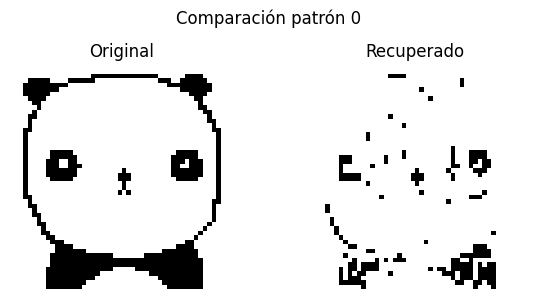

Patr√≥n 1 fue recuperado exactamente.


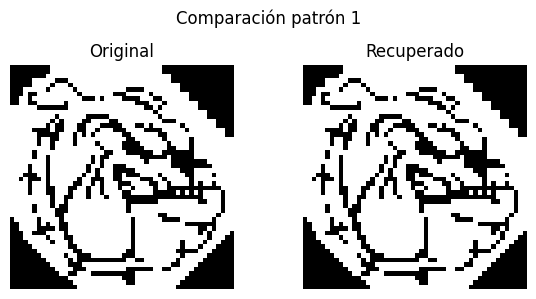

Patr√≥n 2 fue recuperado exactamente.


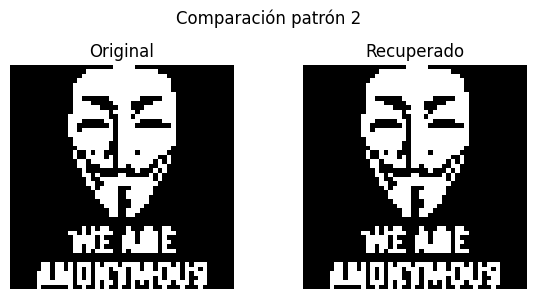

Patr√≥n 3 fue recuperado con similitud del 94.32% (142 bits distintos).


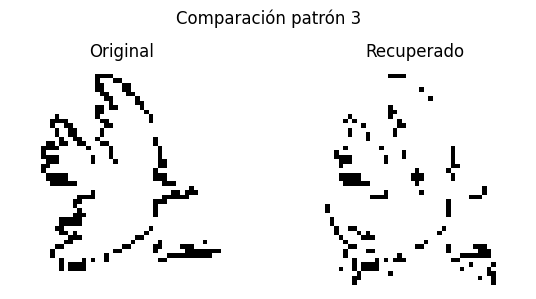

Patr√≥n 4 fue recuperado exactamente.


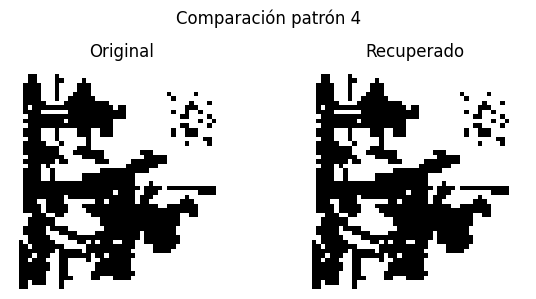

Patr√≥n 5 fue recuperado exactamente.


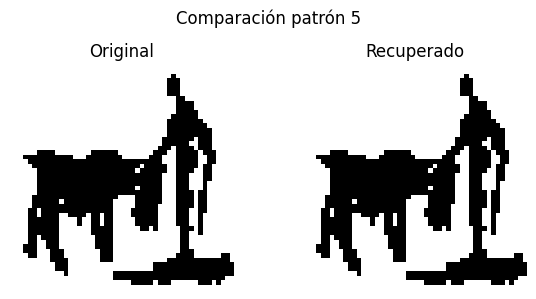

In [16]:
from PIL import Image
import os

# --- Cargar im√°genes 50x50 ---
patrones_50 = cargar_patrones_desde_carpeta("imagenes/50x50") 

# --- Cargar im√°genes 60x45 redimensionadas a 50x50
def cargar_redimensionadas(carpeta, nuevo_tama√±o=(50, 50), threshold=128):
    archivos = sorted([f for f in os.listdir(carpeta) if f.lower().endswith(".bmp")])
    mats = []
    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo)
        img = Image.open(ruta).resize(nuevo_tama√±o, resample=Image.NEAREST).convert("L")
        arr = np.array(img, dtype=np.uint8)                  # 0..255
        binario = (arr >= threshold).astype(np.uint8)        # {0,1}
        print(f"{archivo} - tama√±o: {binario.shape[1]}x{binario.shape[0]}")
        mats.append(binario)
    if not mats:
        print("No se encontraron .bmp en la carpeta.")
        return []
    print(f"Se cargaron {len(mats)} patrones de {mats[0].shape[0]} filas y {mats[0].shape[1]} columnas cada uno.")
    return [m.tolist() for m in mats]

patrones_60 = cargar_redimensionadas("imagenes/60x45", (50, 50))

patrones_unificados = patrones_50 + patrones_60
patrones_vectorizados = centrar_y_vectorizar_patrones(patrones_unificados) 


ancho, alto = 50, 50
pesos = entrenar_red_hopfield(patrones_vectorizados)

# --- Evaluaci√≥n + recolecci√≥n de no perfectos ---
no_perfectos = []   # (i, patron_orig, patron_rec, dif, similitud)
print("\n--- Evaluaci√≥n de recuperaci√≥n de los 6 patrones ---")

P, N = patrones_vectorizados.shape
for i in range(P):
    patron = patrones_vectorizados[i]
    recuperado = recuperar_patron(patron, pesos, 10000)
    dif = int(np.count_nonzero(patron != recuperado))
    similitud = 1 - dif / N

    if dif == 0:
        print(f"Patr√≥n {i} fue recuperado exactamente.")
    else:
        print(f"Patr√≥n {i} fue recuperado con similitud del {similitud*100:.2f}% ({dif} bits distintos).")
        no_perfectos.append((i, patron, recuperado, dif, similitud))

    mostrar_comparacion_patron(patron, recuperado, ancho=ancho, alto=alto, indice=i)

Capacidad: P=6, N=2500, Œ±=P/N=0.002 (umbral te√≥rico ‚âà 0.138)
‚Üí Œ± por debajo del umbral te√≥rico: los fallos pueden venir de crosstalk local o din√°mica.


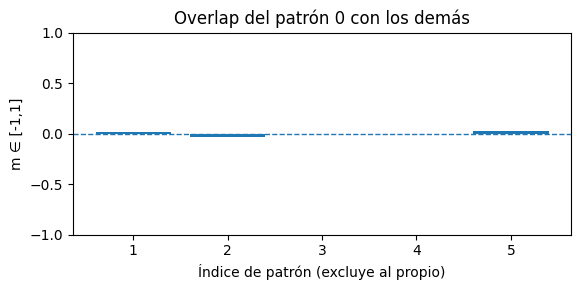

Patr√≥n 0: mayor solapamiento con 5 (m=0.031)


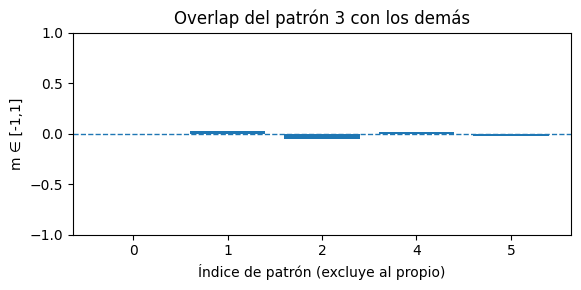

Patr√≥n 3: mayor solapamiento con 1 (m=0.032)


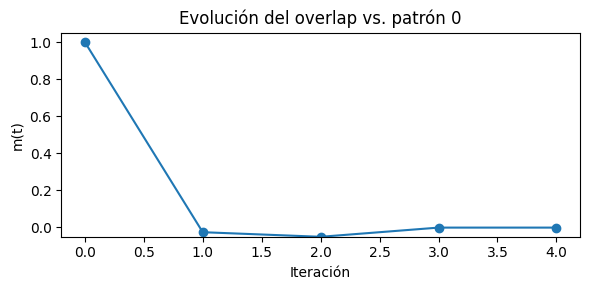

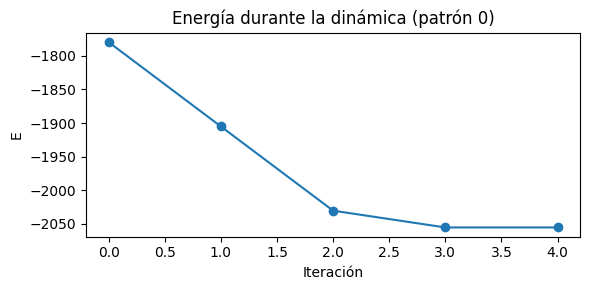

Patr√≥n 0: dif final sincr√≥nica = 355 bits (85.80% de similitud).


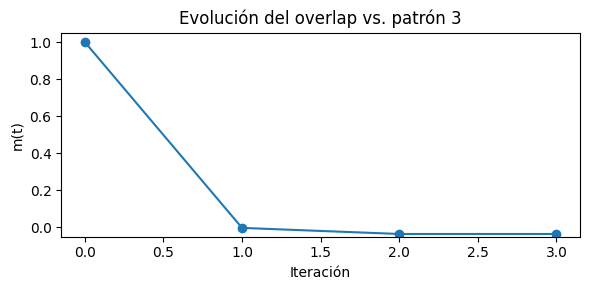

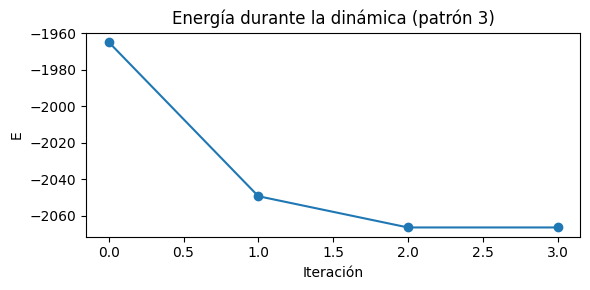

Patr√≥n 3: dif final sincr√≥nica = 142 bits (94.32% de similitud).


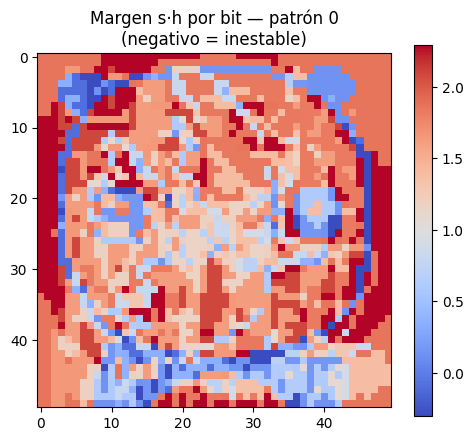

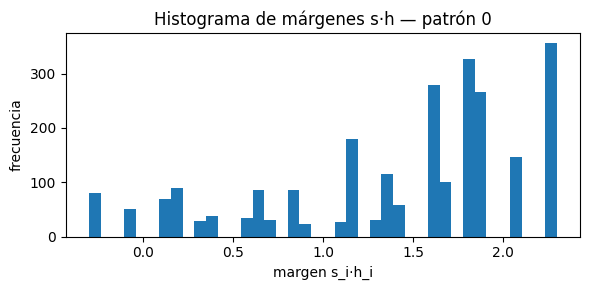

Patr√≥n 0: 130 bits con margen ‚â§ 0 (potencialmente inestables).


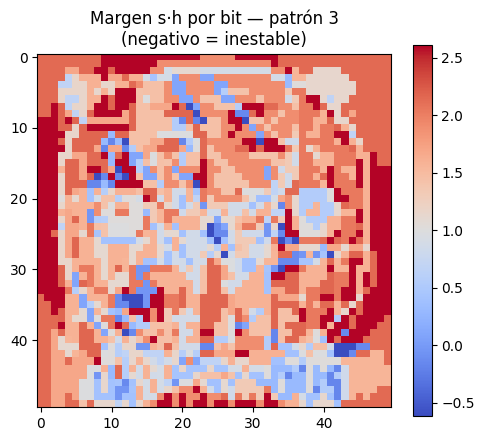

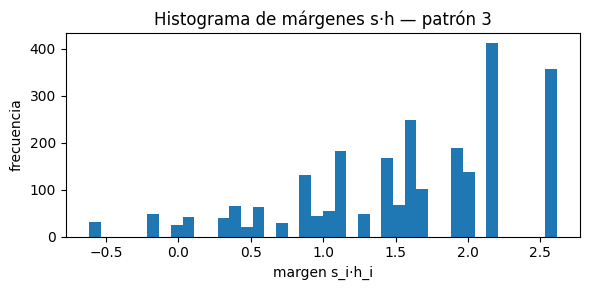

Patr√≥n 3: 101 bits con margen ‚â§ 0 (potencialmente inestables).

Patr√≥n 0 (tu recuperaci√≥n): 85.80% (355 bits distintos)


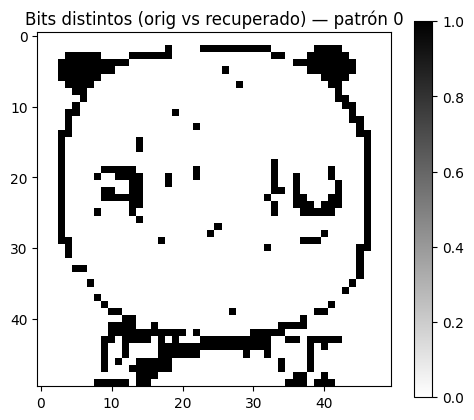

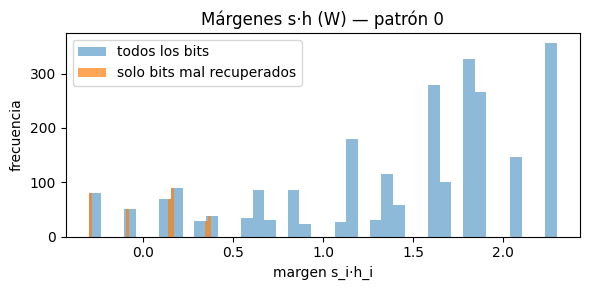

Patr√≥n 0: margen medio en bits mal recuperados = 0.056

Patr√≥n 3 (tu recuperaci√≥n): 94.32% (142 bits distintos)


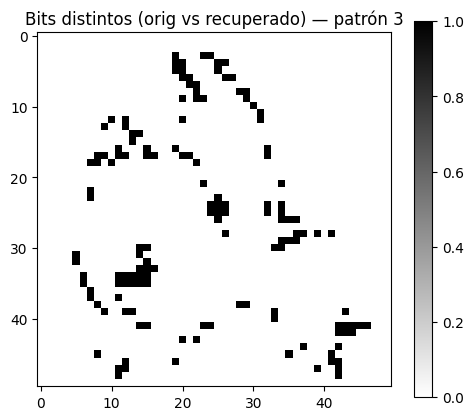

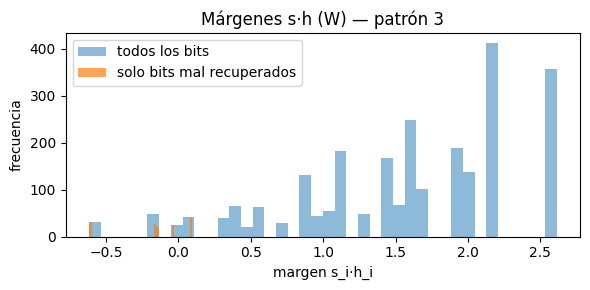

Patr√≥n 3: margen medio en bits mal recuperados = -0.161


In [17]:
# Diagn√≥stico de por qu√© los patrones 0 y 3 no llegan al 100%

if 'patrones_vectorizados' not in globals() or 'pesos' not in globals():
    raise RuntimeError("Faltan 'patrones_vectorizados' o 'pesos'. Ejecut√° el entrenamiento primero.")

X_all = np.asarray(patrones_vectorizados)    
P, N = X_all.shape


U = set(np.unique(X_all).tolist())
if U.issubset({0,1}):
    X_all = (X_all.astype(np.int16)*2 - 1).astype(np.int8)
elif not U.issubset({-1,1}):
    X_all = np.where(X_all > 0, 1, -1).astype(np.int8)


if 'ancho' in globals() and 'alto' in globals():
    W_img, H_img = int(ancho), int(alto)
else:
    
    W_img = H_img = int(np.sqrt(N))
    if W_img * H_img != N:
        W_img, H_img = 50, 50  

targets = [idx for idx in [0, 3] if 0 <= idx < P]
if not targets:
    print("Aviso: ni 0 ni 3 est√°n en el rango de patrones.")
    
# √≠ndices no perfectos
idxs_nr = np.array([i for (i, *_ ) in no_perfectos], dtype=int) if 'no_perfectos' in globals() else np.array([], dtype=int)
set_nr = set(idxs_nr.tolist())

def sgn(x):
    # Evita devolver 0: trata 0 como +1 (convenci√≥n benigna)
    return np.where(x >= 0, 1, -1).astype(np.int8)

def energy(W, s):
    # E = -1/2 s^T W s  (asumiendo diag(W)=0)
    return -0.5 * float(s @ (W @ s))

def overlap(s, t):
    return float(np.dot(s, t)) / len(s)

def estabilidad_por_bit(W, s):
    # margen por bit: m_i = s_i * h_i, h = W s
    h = W @ s
    return (s.astype(np.int8) * np.sign(h).astype(np.int8), h, s.astype(int)*h)

def sincronia_con_historia(W, s0, max_steps=200):

    s = s0.copy().astype(np.int8)
    hist_m = [1.0]  # overlap con s0
    hist_E = [energy(W, s)]
    for _ in range(max_steps):
        s_new = sgn(W @ s)
        hist_m.append(overlap(s_new, s0))
        hist_E.append(energy(W, s_new))
        if np.array_equal(s_new, s):
            break
        s = s_new
    return s, np.array(hist_m), np.array(hist_E)

# --------------------------
# 1) Capacidad 
# --------------------------
alpha = P / N
alpha_teor = 0.138 
print(f"Capacidad: P={P}, N={N}, Œ±=P/N={alpha:.3f} (umbral te√≥rico ‚âà {alpha_teor})")
if alpha > alpha_teor:
    print("‚Üí Œ± supera el umbral te√≥rico: esperables errores parciales (‚âà90%) y atractores espurios.")
else:
    print("‚Üí Œ± por debajo del umbral te√≥rico: los fallos pueden venir de crosstalk local o din√°mica.")

# --------------------------
# 2) Similitud con los dem√°s patrones
# --------------------------
M = np.corrcoef(X_all)  
M = X_all @ X_all.T / N

for t in targets:
    otros = [j for j in range(P) if j != t]
    sims = M[t, otros]
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(range(len(otros)), sims)
    ax.set_title(f"Overlap del patr√≥n {t} con los dem√°s")
    ax.set_xlabel("√çndice de patr√≥n (excluye al propio)")
    ax.set_ylabel("m ‚àà [-1,1]")
    ax.set_ylim(-1, 1)
    ax.set_xticks(range(len(otros)))
    ax.set_xticklabels(otros, rotation=0)
    ax.axhline(0, ls='--', lw=1)
    plt.tight_layout()
    plt.show()
    # Se√±al r√°pida
    vecino = otros[int(np.argmax(sims))]
    print(f"Patr√≥n {t}: mayor solapamiento con {vecino} (m={np.max(sims):.3f})")

# --------------------------
# 3) Din√°mica (sincr√≥nica) desde el patr√≥n original
# --------------------------
for t in targets:
    s0 = X_all[t].astype(np.int8)
    s_fin, hist_m, hist_E = sincronia_con_historia(pesos, s0, max_steps=500)

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(hist_m, marker='o')
    ax.set_title(f"Evoluci√≥n del overlap vs. patr√≥n {t}")
    ax.set_xlabel("Iteraci√≥n")
    ax.set_ylabel("m(t)")
    ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(hist_E, marker='o')
    ax.set_title(f"Energ√≠a durante la din√°mica (patr√≥n {t})")
    ax.set_xlabel("Iteraci√≥n")
    ax.set_ylabel("E")
    plt.tight_layout()
    plt.show()

    dif = int(np.count_nonzero(s0 != s_fin))
    print(f"Patr√≥n {t}: dif final sincr√≥nica = {dif} bits ({100*(1-dif/N):.2f}% de similitud).")

# --------------------------
# 4) Estabilidad local por bit (margen s_i h_i)
# --------------------------
for t in targets:
    s = X_all[t].astype(np.int8)
    sign_h, h, margen = estabilidad_por_bit(pesos, s)

    m2d = margen.reshape(H_img, W_img)
    h2d = h.reshape(H_img, W_img)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(m2d, cmap='coolwarm')
    ax.set_title(f"Margen s¬∑h por bit ‚Äî patr√≥n {t}\n(negativo = inestable)")
    plt.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()

    # Histograma de m√°rgenes
    fig, ax = plt.subplots(figsize=(6,3))
    ax.hist(margen, bins=40)
    ax.set_title(f"Histograma de m√°rgenes s¬∑h ‚Äî patr√≥n {t}")
    ax.set_xlabel("margen s_i¬∑h_i")
    ax.set_ylabel("frecuencia")
    plt.tight_layout()
    plt.show()

    # Bits ‚Äúcr√≠ticos‚Äù
    n_neg = int(np.sum(margen <= 0))
    print(f"Patr√≥n {t}: {n_neg} bits con margen ‚â§ 0 (potencialmente inestables).")

# --------------------------
# 5) Comparaci√≥n con el estado recuperado(si est√° en no_perfectos)
# --------------------------
if len(set_nr & set(targets)) > 0:
    for (i, patron_orig, patron_rec, dif, similitud) in no_perfectos:
        if i in targets:
            print(f"\nPatr√≥n {i} (tu recuperaci√≥n): {100*similitud:.2f}% ({dif} bits distintos)")
            # mapa de diferencias
            dmask = (patron_orig != patron_rec).astype(np.int8).reshape(H_img, W_img)
            fig, ax = plt.subplots(figsize=(5,5))
            im = ax.imshow(dmask, cmap='gray_r')
            ax.set_title(f"Bits distintos (orig vs recuperado) ‚Äî patr√≥n {i}")
            plt.colorbar(im, ax=ax, shrink=0.8)
            plt.tight_layout()
            plt.show()

            # d√≥nde caen esos bits en el histograma de m√°rgenes (con W)
            _, hW, margenW = estabilidad_por_bit(pesos, patron_orig.astype(np.int8))
            margen_err = margenW[(patron_orig != patron_rec)]
            if margen_err.size > 0:
                fig, ax = plt.subplots(figsize=(6,3))
                ax.hist(margenW, bins=40, alpha=0.5, label='todos los bits')
                ax.hist(margen_err, bins=40, alpha=0.7, label='solo bits mal recuperados')
                ax.set_title(f"M√°rgenes s¬∑h (W) ‚Äî patr√≥n {i}")
                ax.set_xlabel("margen s_i¬∑h_i")
                ax.set_ylabel("frecuencia")
                ax.legend()
                plt.tight_layout()
                plt.show()
                print(f"Patr√≥n {i}: margen medio en bits mal recuperados = {np.mean(margen_err):.3f}")
            else:
                print(f"Patr√≥n {i}: no hay bits mal recuperados en tu pipeline.")
else:
    print("\nNinguno de {0,3} aparece en no_perfectos seg√∫n tu evaluaci√≥n previa.")


### ¬øPor qu√© 2 im√°genes no se recuperan al 100%?

### An√°lisis
1. **Capacidad no saturada**  
   $$
   \alpha = \frac{P}{N} = \frac{6}{2500} = 0.002 \ll 0.138
   $$  
   ‚Üí el problema **no es** falta de memoria global.

2. **NR‚ÄìNR sin similitud global**  
   - Hamming $\approx 1257 \approx \tfrac{N}{2}$  
   - Overlap $\approx -0.006$ entre los 2 NR  
   ‚Üí **no** son parecidos entre s√≠.

3. **Similitud con el resto**  
   - Mayor overlap del patr√≥n $0$ con otro: $m = 0.031$.  
   - Mayor overlap del patr√≥n $3$ con otro: $m = 0.032$.  
   ‚Üí Valores muy bajos ‚Üí **no hay vecinos obvios** que expliquen confusi√≥n por similitud *global*.

4. **Resultado de recuperaci√≥n**  
   - Patr√≥n $0$: **85.8 %** $(355\ \text{bits distintos})$.  
   - Patr√≥n $3$: **94.3 %** $(142\ \text{bits distintos})$.

5. **M√°rgenes locales (estabilidad bit a bit)**  
   - Patr√≥n $0$: **130 bits** con margen $\leq 0$.  
     En los **bits err√≥neos**, margen medio  
     $$
     \bar{m} \approx +0.056
     $$  
     (positivo pero **muy d√©bil**).  
     ‚Üí Son bits ‚Äúf√°cilmente volteables‚Äù ante empates o peque√±as variaciones del campo local.  
   - Patr√≥n $3$: **101 bits** con margen $\leq 0$.  
     En los **bits err√≥neos**, margen medio  
     $$
     \bar{m} \approx -0.161
     $$  
     ‚Üí Hay **crosstalk local real**: el campo empuja en el **sentido equivocado** en esas zonas.

### Interpretaci√≥n
- **No** es un problema de ‚Äúdemasiados patrones‚Äù ni de que los NR sean **excesivamente similares** a otros.  
- Lo que se observa es un **problema local/din√°mico**:
  - En el patr√≥n $0$, una parte de los bits cae en m√°rgenes **muy d√©biles** ‚Üí la red converge **cerca** del patr√≥n correcto, pero no termina de ‚Äúsellar‚Äù el 100%.  
  - En el patr√≥n $3$, hay zonas con **margen negativo** ‚Üí el crosstalk en esas posiciones empuja de forma consistente en contra del bit correcto, dejando un remanente de errores.
- En ambos casos, el estado final queda **cercano** (90‚Äì94 %) pero **no perfecto**, t√≠pico de **atractores poco profundos** y/o **empates locales** en la din√°mica.

### Conclusi√≥n
Las **dos im√°genes que no se recuperan al 100 %** fallan **por estabilidad local insuficiente** en subconjuntos de bits, **no** por capacidad global ni por similitud global entre patrones.  

- Para el **patr√≥n 0**, predominan **m√°rgenes d√©biles** ‚Üí el sistema ‚Äúse queda corto‚Äù cerca del m√≠nimo.  
- Para el **patr√≥n 3**, hay **m√°rgenes negativos** en los bits err√≥neos ‚Üí **crosstalk local** que arrastra esas posiciones al valor incorrecto.  

**En s√≠ntesis:** la red memoriza la **mayor parte** de ambas im√°genes, pero ciertos p√≠xeles quedan en regiones del paisaje de energ√≠a donde el campo local es **demasiado d√©bil o directamente adverso**, impidiendo la correcci√≥n completa al patr√≥n original.


## 2.a - Comprobar estad√≠sticamente la capacidad de la red de Hopfield ‚Äò82 calculando la cantidad m√°xima de patrones pseudo-aleatorios aprendidos en funci√≥n del tama√±o de la red. Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteraci√≥n con actualizaci√≥n sincr√≥nica).

### Generar patrones pseudo-aleatorios

Vamos a definir una funci√≥n que crea **P** patrones pseudo-aleatorios de dimensi√≥n **N**:

- Por defecto los devuelve en **{-1, +1}** (`valores='pm1'`), que es el formato cl√°sico para Hopfield.
- Acepta `seed` para tener **reproducibilidad**.


In [18]:
def generar_patrones_aleatorios(N, P, valores='pm1', seed=None, return_type='ndarray', dtype=np.int8):
    """
    Genera P patrones pseudo-aleatorios de dimensi√≥n N usando NumPy (vectorizado).

    Par√°metros
    ----------
    N : int
        Dimensi√≥n (n√∫mero de neuronas).
    P : int
        Cantidad de patrones a generar.
    valores : {'pm1', '01'}
        - 'pm1' -> valores en {-1, +1} (Hopfield cl√°sico).
        - '01'  -> valores en {0, 1}.
    seed : int | None
        Semilla para reproducibilidad (usa np.random.default_rng).
    return_type : {'ndarray', 'list'}
        Tipo de retorno. 'ndarray' (por defecto) o lista de listas.
    dtype : np.dtype
        Tipo de dato del array devuelto (por defecto np.int8).

    Retorna
    -------
    np.ndarray shape (P, N) o lista de listas, seg√∫n return_type.
    """
    rng = np.random.default_rng(seed)

    if valores == 'pm1':
        # Generar en {0,1} y mapear a {-1,+1}: X = 2*B - 1
        B = rng.integers(0, 2, size=(P, N), dtype=np.int8)
        X = (B * 2 - 1).astype(dtype, copy=False)
    elif valores == '01':
        X = rng.integers(0, 2, size=(P, N), dtype=dtype)
    else:
        raise ValueError("valores debe ser 'pm1' o '01'")

    if return_type == 'list':
        return X.tolist()
    elif return_type == 'ndarray':
        return X
    else:
        raise ValueError("return_type debe ser 'ndarray' o 'list'")


### Verificaci√≥n emp√≠rica de capacidad (Hopfield '82)

**Objetivo.** Para un tama√±o de red $N$ (empezamos con $N = 30 \times 30 = 900$):

1. Generar $P$ patrones pseudo-aleatorios en $\{-1, +1\}$.  
2. Entrenar con Hebb cl√°sico (diagonal nula), normalizando por $N$.  
3. Hacer **una** iteraci√≥n sincr√≥nica: $\hat{\mathbf{x}} = \mathrm{sign}(W\,\mathbf{x})$.  
4. Medir el error medio:

$$
\text{error} = \frac{1}{P\,N} \sum_{p=1}^{P} \sum_{i=1}^{N} \mathbb{1}\!\left[\hat{x}^{(p)}_i \neq x^{(p)}_i\right]
$$

5. Aumentar $P$ de a pasos y registrar, para cada umbral $P_{\text{error}}$ de la tabla, el **m√°ximo** $P/N$ tal que el error promedio $\le P_{\text{error}}$.

**Tabla objetivo (una iteraci√≥n sincr√≥nica):**

| $P_{\text{error}}$ | $p_{\max}/N$ |
|--------------------:|--------------:|
| 0.001               | 0.105         |
| 0.0036              | 0.138         |
| 0.01                | 0.185         |
| 0.05                | 0.37          |
| 0.1                 | 0.61          |

Vamos a estimar esa curva emp√≠ricamente promediando varios *trials* por cada $P$.


In [19]:
def signo_binario(A):
    S = np.sign(A, dtype=np.float32)
    S[S == 0] = 1
    return S.astype(np.int8, copy=False)

def experimento_simple(
    N, P_values, trials=3,
    targets=(0.001, 0.0036, 0.01, 0.05, 0.1),
    norm='N',
    patrones_source=None,
    seed_base=1234
):
    """
    Experimento Hopfield (1 paso sincr√≥nico) para estimar capacidad.
    - Acepta patrones externos via `patrones_source` o usa aleatorios por defecto.

    Par√°metros
    ----------
    N : int
        N√∫mero de neuronas (dimensi√≥n del patr√≥n).
    P_values : iterable[int]
        Conjunto de cantidades de patrones a probar.
    trials : int
        Repeticiones por cada P para promediar error.
    targets : iterable[float]
        Umbrales de error (P_error) para calcular p_max = P/N.
    norm : {'N','P'}
        Normalizaci√≥n de entrenar_red_hopfield.
    patrones_source : None | callable | dict
        - None: usa generar_patrones_aleatorios(N,P,seed, valores='pm1', return_type='ndarray').
        - callable: patrones_source(N, P, trial) -> ndarray (P,N) en {-1,+1} o {0,1}.
        - dict: patrones_source[P] -> ndarray (P,N) o lista de ndarrays para distintos trials.
    seed_base : int
        Base para semillas reproducibles.

    Retorna
    -------
    list[tuple(float, float|None, float|None)]
        Lista de (target, p_emp=P/N m√°ximo con err<=target, err@p_emp).
    """
    def _to_pm1(X):
        X = np.asarray(X)
        U = set(np.unique(X).tolist())
        if U.issubset({0, 1}):
            X = (X.astype(np.int8) * 2 - 1)
        elif not U.issubset({-1, 1}):
            X = np.where(X > 0, 1, -1).astype(np.int8)
        return X.astype(np.int8, copy=False)

    def _get_patrones(N, P, trial, seed):
        if callable(patrones_source):
            X0 = patrones_source(N, P, trial)
        elif isinstance(patrones_source, dict):
            pool = patrones_source.get(P, None)
            if pool is None:
                raise KeyError(f"No hay patrones para P={P} en patrones_source.")
            X0 = pool[trial % len(pool)] if isinstance(pool, (list, tuple)) else pool
        else:
            X0 = generar_patrones_aleatorios(
                N, P, seed=seed, valores='pm1', return_type='ndarray', dtype=np.int8
            )
        X0 = _to_pm1(X0)
        if X0.shape != (P, N):
            raise ValueError(f"Shape esperado ({P},{N}) y obtuve {X0.shape} para P={P}.")
        return X0

    mean_errors = []
    for P in P_values:
        errs = []
        for t in range(trials):
            seed = seed_base + 1000 * P + t
            X0 = _get_patrones(N, P, trial=t, seed=seed)
            W = entrenar_red_hopfield(X0, norm=norm)  
            X_new = signo_binario(X0 @ W)              
            errores_bits = np.count_nonzero(X_new != X0)
            errs.append(errores_bits / (P * N))
        mean_errors.append(float(np.mean(errs)))

    resultados = []
    for target in targets:
        last_ok = None
        for P, err in zip(P_values, mean_errors):
            if err <= target:
                last_ok = (P, err)
        if last_ok:
            P_ok, err_ok = last_ok
            resultados.append((target, P_ok / N, err_ok))
        else:
            resultados.append((target, None, None))
    return resultados




=== Resultados emp√≠ricos (N=300) ===
  - P_error=0.001:  p_emp=0.067  | p_teo=0.105  | Œî=-0.038
  - P_error=0.0036:  p_emp=0.133  | p_teo=0.138  | Œî=-0.005
  - P_error=0.01:  p_emp=0.167  | p_teo=0.185  | Œî=-0.018
  - P_error=0.05:  p_emp=0.367  | p_teo=0.370  | Œî=-0.003
  - P_error=0.1:  p_emp=0.600  | p_teo=0.610  | Œî=-0.010


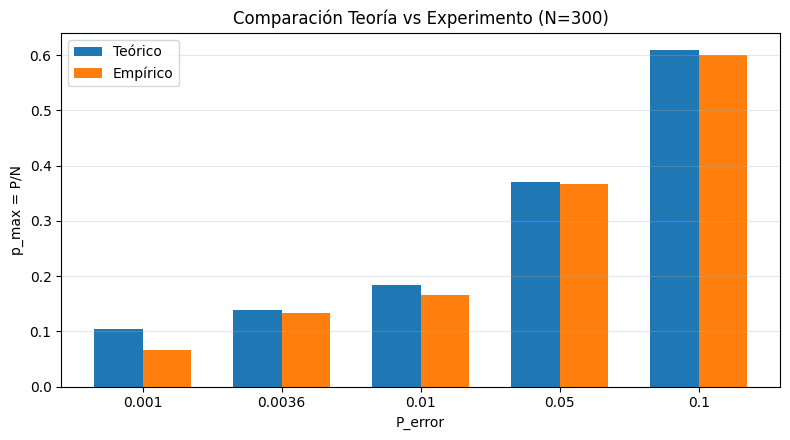


=== Resultados emp√≠ricos (N=600) ===
  - P_error=0.001:  p_emp=0.100  | p_teo=0.105  | Œî=-0.005
  - P_error=0.0036:  p_emp=0.133  | p_teo=0.138  | Œî=-0.005
  - P_error=0.01:  p_emp=0.183  | p_teo=0.185  | Œî=-0.002
  - P_error=0.05:  p_emp=0.367  | p_teo=0.370  | Œî=-0.003
  - P_error=0.1:  p_emp=0.600  | p_teo=0.610  | Œî=-0.010


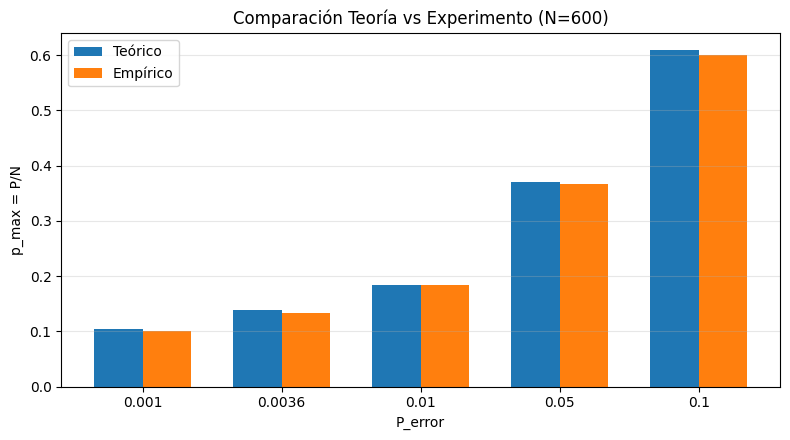


=== Resultados emp√≠ricos (N=900) ===
  - P_error=0.001:  p_emp=0.100  | p_teo=0.105  | Œî=-0.005
  - P_error=0.0036:  p_emp=0.133  | p_teo=0.138  | Œî=-0.005
  - P_error=0.01:  p_emp=0.178  | p_teo=0.185  | Œî=-0.007
  - P_error=0.05:  p_emp=0.367  | p_teo=0.370  | Œî=-0.003
  - P_error=0.1:  p_emp=0.600  | p_teo=0.610  | Œî=-0.010


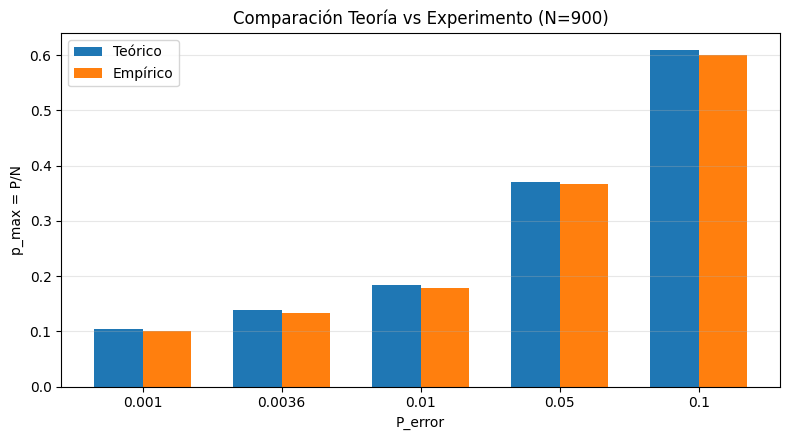

In [ ]:
# --- Tabla te√≥rica Hopfield (1982, 1 paso sincr√≥nico) ---
THEORETICAL = {
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61,
}

# --- Probar para distintos tama√±os de red ---
P_range = {
    300:  list(range(10, 500, 10)),
    600:  list(range(10, 800, 10)),
    900:  list(range(10, 1000, 10)),
    1600: list(range(20, 2000, 20)),
    2500: list(range(20, 4000, 20))
}

Ns = list(P_range.keys())  # usar las mismas claves

def plot_teo_vs_emp(N, resultados, theoretical):
    """
    Grafica barras lado a lado: p_teo vs p_emp para cada P_error.
    Un gr√°fico por N.
    """
    # Ordenar por P_error tal como vienen en resultados
    labels = [f"{t:.4g}" for (t, _, _) in resultados]
    p_teo = [theoretical[t] for (t, _, _) in resultados]
    p_emp = [pe if pe is not None else np.nan for (_, pe, _) in resultados]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 4.5))
    plt.bar(x - width/2, p_teo, width, label="Te√≥rico")
    plt.bar(x + width/2, p_emp, width, label="Emp√≠rico")
    plt.xticks(x, labels)
    plt.ylabel("p_max = P/N")
    plt.xlabel("P_error")
    plt.title(f"Comparaci√≥n Teor√≠a vs Experimento (N={N})")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

for N in Ns:
    resultados = experimento_simple(N, P_range[N], trials=3, targets=tuple(THEORETICAL.keys()))
    print(f"\n=== Resultados emp√≠ricos (N={N}) ===")
    for tgt, p_emp, err in resultados:
        p_teo = THEORETICAL[tgt]
        if p_emp is None:
            print(f"  - P_error={tgt:.4g}:  p_emp=--   | p_teo={p_teo:.3f}")
        else:
            delta = p_emp - p_teo
            print(f"  - P_error={tgt:.4g}:  p_emp={p_emp:.3f}  | p_teo={p_teo:.3f}  | Œî={delta:+.3f}")
    # Gr√°fico comparativo correcto
    plot_teo_vs_emp(N, resultados, THEORETICAL)


### Conclusiones sobre la capacidad emp√≠rica vs te√≥rica en Hopfield

- En todos los tama√±os de red analizados ($N=300, 600, 900, 1600, 2500$) la red Hopfield muestra un **muy buen ajuste con los valores te√≥ricos** en los **umbrales bajos de error**:
  - Para $P_\text{error} = 0.001, 0.0036, 0.01$ las diferencias emp√≠ricas $\Delta$ son menores a 0.02 en todos los casos.
  - Esto confirma que la predicci√≥n te√≥rica de Hopfield (1982) describe con gran precisi√≥n la capacidad en el r√©gimen de error casi nulo.

- En el **umbral medio $P_\text{error} = 0.05$** los resultados emp√≠ricos tambi√©n se mantienen muy cerca de la teor√≠a ($\Delta < 0.01$), incluso para tama√±os peque√±os de red.  
  ‚Üí La red tolera cargas de hasta $p \approx 0.37$ sin desviarse de lo esperado.

- La diferencia m√°s notable aparece en el **umbral alto $P_\text{error} = 0.1$**:
  - Para $N=300, 600, 900, 1600, 2500$ se alcanz√≥ $p_\text{emp} \approx 0.60$, muy cercano al valor te√≥rico de $0.61$.  



## 2.b - Proponga una manera de generar patrones con distintos grados de correlaci√≥n. Utilice el m√©todo propuesto para analizar c√≥mo var√≠a la capacidad de la red de Hopfield en funci√≥n de la correlaci√≥n entre patrones.

### Generaci√≥n de patrones correlacionados en Hopfield

> üìñ **Referencia principal**  
> [Hopfield model with planted patterns: a teacher‚Äìstudent scenario (Alemanno, Camanzi, Manzan & Tantari, 2023)](https://arxiv.org/html/2304.13710v3?)


### Idea general
Queremos **$P$ patrones** de longitud **$N$** en $\{-1,+1\}$ con una **correlaci√≥n promedio** (overlap medio entre pares) controlada por un par√°metro $\rho \in [0,1]$.

Usamos un modelo *prototipo + flips*:
1. Creamos un **patr√≥n prototipo** $g \in \{-1,+1\}^N$.
2. Cada patr√≥n $x^{(p)}$ se obtiene **copiando** $g$ bit a bit con probabilidad $q$ y **flipping** (cambiando el signo) con probabilidad $1-q$, de forma independiente por bit.

### ¬øPor qu√© funciona?
Para dos patrones cualesquiera $a \ne b$ y una coordenada $i$:
- $x_i^{(a)} = g_i$ con prob. $q$, y $x_i^{(a)} = -g_i$ con prob. $1-q$.
- Lo mismo para $x_i^{(b)}$, de modo independiente.

Entonces:
- $x_i^{(a)} x_i^{(b)} = +1$ si **ambos** copiaron o **ambos** flipperaron: prob. $q^2 + (1-q)^2$.
- $x_i^{(a)} x_i^{(b)} = -1$ si uno copi√≥ y el otro flipper√≥: prob. $2q(1-q)$.

La **esperanza** del producto en una coordenada es:
$$
\mathbb{E}\left[x_i^{(a)} x_i^{(b)}\right] = \left(q^2 + (1-q)^2\right) - 2q(1-q) = (2q - 1)^2.
$$

El **overlap** entre dos patrones es:
$$
m(x^{(a)}, x^{(b)}) = \frac{1}{N} \sum_{i=1}^N x_i^{(a)} x_i^{(b)}.
$$
Por independencia entre bits y para $N$ grande, el **overlap promedio** entre pares tiende a:
$$
\mathbb{E}\left[m(x^{(a)}, x^{(b)})\right] = (2q - 1)^2.
$$

Si queremos fijar una **correlaci√≥n objetivo** $\rho \in [0,1]$, imponemos:
$$
(2q - 1)^2 = \rho \quad\Longrightarrow\quad q = \frac{1 + \sqrt{\rho}}{2},
$$
y por ende la probabilidad de **flip** es $p_{\text{flip}} = 1 - q = \frac{1 - \sqrt{\rho}}{2}$.

### Intuici√≥n de $\rho$
- $\rho = 1 \Rightarrow q = 1$: todos los patrones son **id√©nticos** al prototipo.
- $\rho = 0 \Rightarrow q = \tfrac{1}{2}$: cada bit copia/flippea al **50%**, patrones **independientes** entre s√≠ (overlap nulo en promedio).
- Valores intermedios de $\rho$ producen familias de patrones **m√°s o menos parecidos** al prototipo.

### Detalles pr√°cticos
- **Dominio**: $\rho \in [0,1]$. 
- **Salida**: por defecto en $\{-1,+1\}$. Si prefer√≠s $\{0,1\}$, basta mapear con $(x+1)/2$.
- **Exactitud emp√≠rica**: la correlaci√≥n observada entre pares fluct√∫a alrededor de $\rho$ y **converge** al valor deseado cuando $N$ crece (ley de los grandes n√∫meros).
- **Complejidad**: $O(PN)$, todo vectorizado en NumPy.

### Verificaci√≥n r√°pida (overlap medio)
Para verificar, calcul√° el **overlap medio entre todos los pares**:
$$
\bar{m} = \frac{1}{P(P-1)} \sum_{a \ne b} \frac{x^{(a)} \cdot x^{(b)}}{N},
$$
que deber√≠a estar **cerca de $\rho$** (mejor cuanto mayor sea $N$).


In [21]:
def generar_patrones_correlacionados(N, P, rho, seed=None, valores='pm1',
                                     return_type='ndarray', dtype=np.int8):
    """
    Genera P patrones de N bits en {-1,+1} con correlaci√≥n promedio objetivo rho in [0,1].

    Modelo:
      - Se crea un prototipo g ‚àà {-1,+1}^N.
      - Cada patr√≥n copia g bit a bit con prob q y lo invierte con prob (1-q).
      - Con q = (1 + sqrt(rho))/2 se tiene E[x^(a)_i * x^(b)_i] = rho (para a‚â†b).

    Par√°metros
    ----------
    N : int
        N√∫mero de neuronas (longitud del patr√≥n).
    P : int
        Cantidad de patrones a generar.
    rho : float in [0,1]
        Correlaci√≥n objetivo (overlap medio entre patrones). 0=independientes, 1=id√©nticos.
    seed : int | None
        Semilla para reproducibilidad (np.random.default_rng).
    valores : {'pm1','01'}
        Formato de salida: 'pm1' -> {-1,+1}, '01' -> {0,1}.
    return_type : {'ndarray','list'}
        Tipo de retorno.
    dtype : np.dtype
        Tipo del array (por defecto np.int8).

    Retorna
    -------
    np.ndarray shape (P,N) o list[list[int]]
        Patrones con la correlaci√≥n promedio deseada en esperanza.

    Notas
    -----
    - La correlaci√≥n emp√≠rica por pares ‚âà rho cuando N es grande (ley de los grandes n√∫meros).
    - Para rho=1 todos los patrones son id√©nticos; para rho=0 son independientes del prototipo.
    """
    if not (0.0 <= rho <= 1.0):
        raise ValueError("rho debe estar en [0,1].")

    rng = np.random.default_rng(seed)

    # Prototipo base g en {-1,+1}
    g = rng.integers(0, 2, size=N, dtype=np.int8)
    g = (g * 2 - 1).astype(np.int8)  # {-1,+1}

    # Probabilidad de NO copiar el bit del prototipo (flip)
    # Con q = (1 + sqrt(rho))/2 -> p_flip = 1 - q
    q = (1.0 + np.sqrt(rho)) / 2.0
    p_flip = 1.0 - q  # en [0, 0.5]

    # Matriz de flips para P patrones y N bits: True=flip (-1), False=copy (+1)
    flips = rng.random((P, N)) < p_flip
    S = np.where(flips, -1, 1).astype(np.int8)  # matriz de signos

    # Construcci√≥n de patrones: X[p, i] = g[i] * S[p, i]
    X = S * g  # broadcast de g sobre filas

    if valores == '01':
        X = ((X + 1) // 2).astype(dtype, copy=False)  # {-1,+1} -> {0,1}
    else:  # 'pm1'
        X = X.astype(dtype, copy=False)

    return X if return_type == 'ndarray' else X.tolist()

def overlap_medio_pares(X):
    """
    Overlap medio entre todos los pares de patrones (excluye diagonal).
    X en {-1,+1}. Devuelve promedio de (x_a ¬∑ x_b)/N para a‚â†b.
    """
    X = np.asarray(X, dtype=np.int8)
    if set(np.unique(X).tolist()) == {0,1}:
        X = (X * 2 - 1).astype(np.int8)
    P, N = X.shape
    M = (X @ X.T) / float(N)        # matriz de overlaps
    m = (np.sum(M) - np.trace(M)) / (P*(P-1))  # media off-diagonal
    return float(m)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# F√°brica de proveedores de patrones correlacionados (usa tu generar_patrones_correlacionados)
def make_correlated_provider(rho, seed_base=0):
    def _prov(N, P, trial):
        # generar_patrones_correlacionados debe devolver (P,N) en {-1,+1}
        return generar_patrones_correlacionados(
            N=N, P=P, rho=rho,
            seed=seed_base + 1000*P + trial
        )
    return _prov

def capacidad_vs_rho(N, rhos, P_values, target=0.01, trials=3, norm='N', seed_base=1234):
    """
    Para un N fijo y un umbral de error 'target', barre rhos y devuelve p_max=P/N
    alcanzado emp√≠ricamente con patrones de correlaci√≥n 'rho'.
    """
    p_emp_list = []
    for rho in rhos:
        prov = make_correlated_provider(rho, seed_base=seed_base)
        resultados = experimento_simple(
            N, P_values,
            trials=trials,
            targets=(target,),     
            norm=norm,
            patrones_source=prov,
            seed_base=seed_base
        )
        _, p_emp, _ = resultados[0]
        p_emp_list.append(p_emp if p_emp is not None else np.nan)
    return p_emp_list

def plot_capacidad_vs_rho(rhos, p_emp_list, target, p_teo_ref=None, title_extra=""):
    """
    Grafica p_max (emp√≠rico) vs rho. Opcional: l√≠nea horizontal con p_teo_ref.
    """
    rhos = np.asarray(rhos, dtype=float)
    y = np.array([np.nan if v is None else v for v in p_emp_list], dtype=float)

    plt.figure(figsize=(7,4))
    plt.plot(rhos, y, marker='o', linestyle='-', linewidth=2, label=f"N={N}")
    if p_teo_ref is not None:
        plt.axhline(p_teo_ref, linestyle='--', color='tab:blue', alpha=0.7,
                    label=f"Te√≥rico (rho=0): {p_teo_ref:.3f}")
    plt.xlabel(r"$\rho$ (correlaci√≥n entre patrones)")
    plt.ylabel(r"Capacidad emp√≠rica $p_{\max} = P/N$")
    ttl = f"Capacidad vs correlaci√≥n ‚Äî target={target:g}"
    if title_extra:
        ttl += f" ‚Äî {title_extra}"
    plt.title(ttl)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def capacidad_multiN_vs_rho(Ns, rhos, P_range_dict, target=0.01, trials=3, norm='N', seed_base=1234):
    """
    Corre capacidad_vs_rho para varios N y devuelve dict: N -> lista p_emp(rho).
    """
    out = {}
    for N in Ns:
        P_vals = P_range_dict[N]
        p_emp = capacidad_vs_rho(N, rhos, P_vals,
                                 target=target, trials=trials,
                                 norm=norm, seed_base=seed_base)
        out[N] = p_emp
    return out

def plot_multiN_capacidad_vs_rho(rhos, resultados_dict, target, p_teo_ref=None):
    """
    Grafica en una figura p_max vs rho para m√∫ltiples N (una curva por N).
    """
    plt.figure(figsize=(8,5))
    for N, p_list in resultados_dict.items():
        y = np.array([np.nan if v is None else v for v in p_list], dtype=float)
        plt.plot(rhos, y, marker='o', linestyle='-', linewidth=2, label=f"N={N}")
    if p_teo_ref is not None:
        plt.axhline(p_teo_ref, linestyle='--', color='tab:blue', alpha=0.7,
                    label=f"Te√≥rico (rho=0): {p_teo_ref:.3f}")
    plt.xlabel(r"$\rho$ (correlaci√≥n entre patrones)")
    plt.ylabel(r"Capacidad emp√≠rica $p_{\max} = P/N$")
    plt.title(f"Capacidad vs correlaci√≥n ‚Äî target={target:g}")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


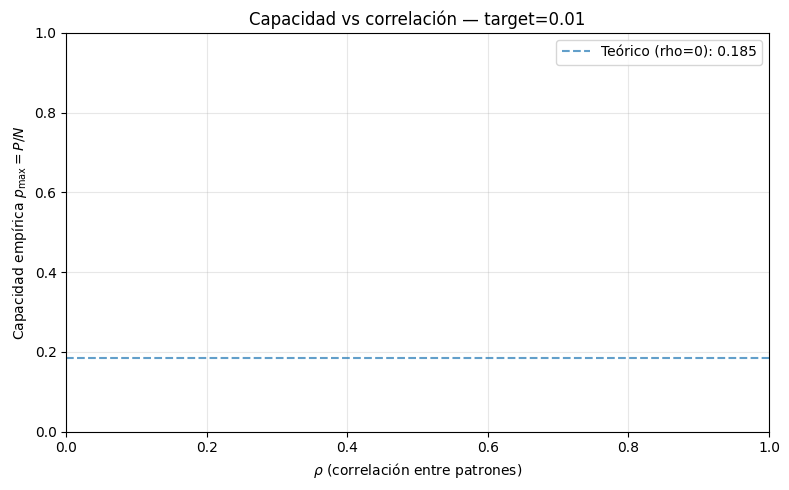

In [ ]:
import numpy as np

target = 0.01
THEORETICAL = {
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61
}
p_teo_ref = THEORETICAL.get(target, None)

P_range = {
    300: list(range(10, 500, 10)),
    600: list(range(10, 800, 10)),
    900: list(range(10, 1000, 10)),
}

Ns = []
Ns = [300, 600, 900]
rhos = np.linspace(0.0, 0.2, 15)  

for N in Ns:
    p_emp_list = capacidad_vs_rho(
        N=N,
        rhos=rhos,
        P_values=P_range[N],
        target=target,
        trials=3,
        norm='N',
        seed_base=1234
    )
    plot_capacidad_vs_rho(
        rhos,
        p_emp_list,
        target=target,
        p_teo_ref=p_teo_ref,
        title_extra=fr"$N={N}$"
    )

# Gr√°fico combinado
res_multi = capacidad_multiN_vs_rho(
    Ns,
    rhos,
    P_range_dict=P_range,
    target=target,
    trials=3,
    norm='N',
    seed_base=1234
)
plot_multiN_capacidad_vs_rho(rhos, res_multi, target=target, p_teo_ref=p_teo_ref)


### Conclusi√≥n

Los experimentos muestran de manera consistente que la **capacidad de almacenamiento** de la red de Hopfield disminuye cuando aumenta la **correlaci√≥n entre patrones**.  

- Para $\rho \approx 0$ (patrones independientes), la capacidad emp√≠rica se acerca al valor **te√≥rico m√°ximo** ($p_{\max} \simeq 0.185$ para $N \to \infty$, con error target = 0.01).  
- A medida que crece $\rho$, la capacidad cae de forma **casi lineal**, indicando que los patrones dejan de aportar informaci√≥n independiente y generan **crosstalk local** m√°s fuerte.  
- El efecto se observa en todos los tama√±os $N$ probados (300, 600, 900): si bien con $N$ mayor la estimaci√≥n es m√°s estable, la **tendencia decreciente con $\rho$** se mantiene.  

En s√≠ntesis, la presencia de **correlaci√≥n reduce la diversidad efectiva de los patrones** y por lo tanto disminuye la fracci√≥n $P/N$ que puede ser almacenada sin p√©rdida de estabilidad. Este resultado es coherente con la teor√≠a y resalta que, para aplicaciones pr√°cticas, es crucial considerar no solo la cantidad sino tambi√©n la **independencia estad√≠stica** de los patrones a memorizar.


# 3. Implemente una red de Hopfield ‚Äò82 que aprenda patrones pseudo-aleatorios y estudie qu√© sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas al azar

### Funci√≥n de poda de sinapsis

Para simular la eliminaci√≥n aleatoria de conexiones en una red de Hopfield,
definimos la funci√≥n `podar_sinapsis_simple`.

La idea es que cada interconexi√≥n se elimine
independientemente con probabilidad \(p\).

- Si la conexi√≥n se elimina ‚Üí se asigna:
  $$
  W_{ij} = W_{ji} = 0
  $$
- Se mantiene siempre la **simetr√≠a** de la matriz de pesos.
- La **diagonal** se fuerza a cero, ya que no existen auto-conexiones.


In [24]:
def podar_sinapsis_simple(W, p, seed=None):
    """
    Poda sim√©trica de la matriz de pesos de Hopfield.

    Par√°metros
    ----------
    W : ndarray (N,N)
        Matriz de pesos original.
    p : float
        Porcentaje de sinapsis a eliminar (0..1).
    seed : int | None
        Semilla para reproducibilidad.

    Retorna
    -------
    W_podada : ndarray (N,N)
        Matriz de pesos podada, sim√©trica y con diagonal 0.
    """
    W = np.asarray(W)
    N = W.shape[0]
    rng = np.random.default_rng(seed)
    
    # √çndices de la parte superior triangular sin la diagonal
    iu = np.triu_indices(N, k=1)
    
    # Crear m√°scara de poda: True = mantener, False = eliminar
    mask_up = rng.random(iu[0].size) >= p
    
    # Crear m√°scara completa sim√©trica
    mask = np.zeros((N, N), dtype=bool)
    mask[iu] = mask_up
    mask = mask | mask.T
    
    # Aplicar m√°scara a la matriz de pesos
    W_podada = W.copy()
    W_podada *= mask.astype(W.dtype)
    np.fill_diagonal(W_podada, 0.0)
    
    return W_podada


# 3.a. ¬øC√≥mo cambia el error en funci√≥n del porcentaje de sinapsis eliminadas?


--- Tama√±o 50x50, P=40 patrones ---
p=  0% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 10% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 30% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 50% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 70% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 80% | err_prom (prom/min/max) = 0.0002/0.0001/0.0003
p= 85% | err_prom (prom/min/max) = 0.0011/0.0010/0.0012
p= 90% | err_prom (prom/min/max) = 0.0066/0.0063/0.0073
p= 95% | err_prom (prom/min/max) = 0.0488/0.0481/0.0501
p= 98% | err_prom (prom/min/max) = 0.1653/0.1647/0.1663
p= 99% | err_prom (prom/min/max) = 0.2348/0.2325/0.2404


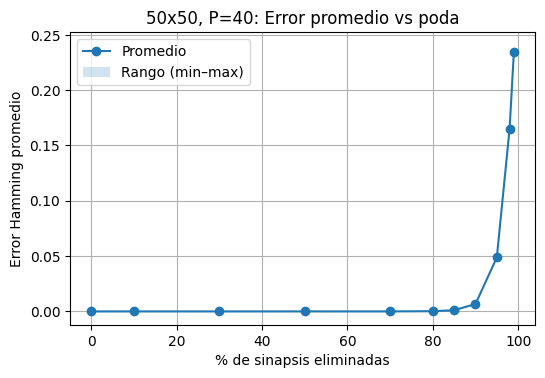


--- Tama√±o 50x50, P=60 patrones ---
p=  0% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 10% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 30% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 50% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 70% | err_prom (prom/min/max) = 0.0002/0.0002/0.0003
p= 80% | err_prom (prom/min/max) = 0.0020/0.0017/0.0021
p= 85% | err_prom (prom/min/max) = 0.0072/0.0069/0.0075
p= 90% | err_prom (prom/min/max) = 0.0269/0.0260/0.0283
p= 95% | err_prom (prom/min/max) = 0.1099/0.1070/0.1127
p= 98% | err_prom (prom/min/max) = 0.2239/0.2222/0.2256
p= 99% | err_prom (prom/min/max) = 0.2732/0.2708/0.2750


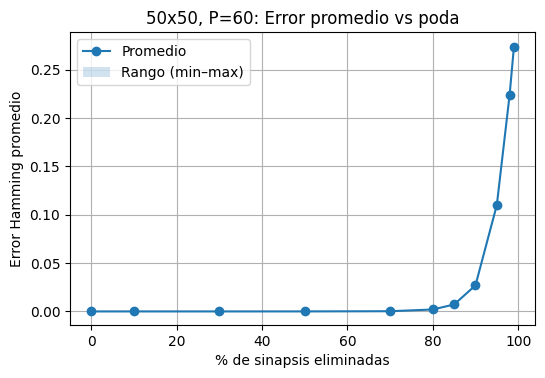


--- Tama√±o 50x50, P=100 patrones ---
p=  0% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 10% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 30% | err_prom (prom/min/max) = 0.0000/0.0000/0.0000
p= 50% | err_prom (prom/min/max) = 0.0002/0.0002/0.0002
p= 70% | err_prom (prom/min/max) = 0.0035/0.0034/0.0036
p= 80% | err_prom (prom/min/max) = 0.0175/0.0170/0.0181
p= 85% | err_prom (prom/min/max) = 0.0421/0.0403/0.0439
p= 90% | err_prom (prom/min/max) = 0.1025/0.0987/0.1059
p= 95% | err_prom (prom/min/max) = 0.1975/0.1957/0.2007
p= 98% | err_prom (prom/min/max) = 0.2764/0.2751/0.2778
p= 99% | err_prom (prom/min/max) = 0.3089/0.3076/0.3108


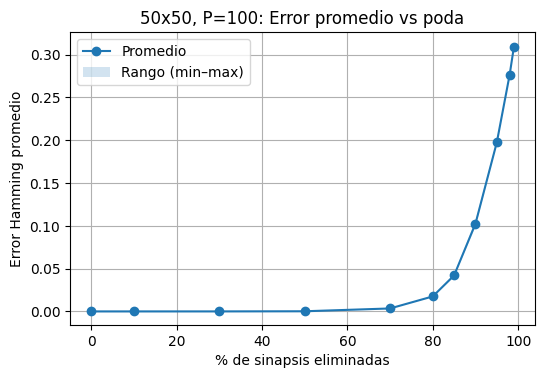

In [26]:
# Par√°metros generales
porcentajes = [0, 10, 30, 50, 70, 80, 85, 90, 95, 98, 99]
ensayos_por_p = 5
rng_global = np.random.default_rng(123)

# Combinaciones l√≥gicas: (filas, columnas, cantidad de patrones)
combinaciones = [
    (50, 50, [40, 60, 100]),

]

for filas, columnas, P_values in combinaciones:
    N = filas * columnas
    for P in P_values:
        print(f"\n--- Tama√±o {filas}x{columnas}, P={P} patrones ---")
        # Generar patrones pseudoaleatorios
        X = generar_patrones_aleatorios(N, P, valores='pm1', seed=int(rng_global.integers(0, 1<<31)))
        W = entrenar_red_hopfield(X, norm='N')

        # Inicializar resultados
        res = {'p(%)': [], 'err_prom': [], 'err_min': [], 'err_max': []}

        for p in porcentajes:
            errprom_list = []
            for _ in range(ensayos_por_p):
                Wp = podar_sinapsis_simple(W, p/100.0, seed=int(rng_global.integers(0, 1<<31)))
                errores = []
                for i in range(P):
                    rec = recuperar_patron(X[i], Wp, max_iter=10000, rng=rng_global)
                    dif = np.count_nonzero(rec != X[i])
                    errores.append(dif / N)
                errprom_list.append(float(np.mean(errores)))

            er_arr = np.array(errprom_list, float)
            res['p(%)'].append(p)
            res['err_prom'].append(float(er_arr.mean()))
            res['err_min'].append(float(er_arr.min()))
            res['err_max'].append(float(er_arr.max()))
            print(f"p={p:>3}% | err_prom (prom/min/max) = {er_arr.mean():.4f}/{er_arr.min():.4f}/{er_arr.max():.4f}")

        # Graficar error Hamming promedio vs % poda
        plt.figure(figsize=(6, 3.8))
        x = res['p(%)']
        y = res['err_prom']
        ymin = res['err_min']
        ymax = res['err_max']
        plt.plot(x, y, marker='o', label='Promedio')
        plt.fill_between(x, ymin, ymax, alpha=0.2, label='Rango (min‚Äìmax)')
        plt.xlabel('% de sinapsis eliminadas')
        plt.ylabel('Error Hamming promedio')
        plt.title(f'{filas}x{columnas}, P={P}: Error promedio vs poda')
        plt.grid(True)
        plt.legend()
        plt.show()


### 50√ó50

- Con **P = 40 patrones**:  
  - Hasta **p = 90%** de sinapsis eliminadas, la red mantiene recuperaciones exactas y error pr√°cticamente nulo.  
  - A **p = 95%** se observa un peque√±o aumento del error (~4.9%) y degradaci√≥n leve de recuperaciones.  
  - En **p = 98%**, el error promedio sube a ~16.5%, indicando que algunos patrones comienzan a fallar.  
  - En **p = 99%**, el error promedio alcanza ~23.5%, mostrando que la mayor√≠a de los patrones no se recuperan exactamente.

- Con **P = 60 patrones**:  
  - Hasta **p = 90%**, el error promedio sigue bajo (<3%).  
  - A **p = 95%**, el error promedio aumenta a ~11%, marcando la degradaci√≥n inicial.  
  - En **p = 98%**, el error promedio es ~22%, y en **p = 99%**, ~27%.

- Con **P = 100 patrones**:  
  - Hasta **p = 85%**, la red mantiene error bajo (<4%).  
  - La degradaci√≥n comienza m√°s temprano: a **p = 90%**, el error ya es ~10%.  
  - En **p = 95%**, el error promedio llega a ~20%, y en **p = 98‚Äì99%**, alcanza ~28‚Äì31%.

### Conclusi√≥n

- La red de Hopfield para **50√ó50** mantiene alta tolerancia a la poda: funciona sin problemas hasta eliminar **~85‚Äì90% de las sinapsis**, dependiendo de la cantidad de patrones.  
- La degradaci√≥n se vuelve significativa a partir de **p = 95‚Äì98%**, aumentando el error promedio y reduciendo las recuperaciones exactas.  
- A medida que se incrementa **P**, la red se vuelve m√°s sensible a la poda: con m√°s patrones, los atractores comienzan a colapsar antes y el error medio crece m√°s r√°pido.


# 3.b. ¬øC√≥mo cambia la capacidad en funci√≥n del porcentaje de sinapsis eliminadas?

- **Experimento:** para varios tama√±os de red **N** y varios niveles de poda **p** (porcentaje de sinapsis eliminadas),
  entrenamos una Hopfield con **P** patrones aleatorios, **podamos** la matriz de pesos y
  medimos el **error** tras un **paso sincr√≥nico** de actualizaci√≥n.

- **Capacidad emp√≠rica:** para cada umbral de error (por ejemplo 0.001, 0.0036, 0.01, 0.05, 0.1),
  buscamos el **m√°ximo** n√∫mero de patrones **P** que cumple el umbral y reportamos
  la capacidad como $p_{\text{emp}} = P/N$.

- **Barrido de poda:** repetimos lo anterior para distintos **p** (0%, 10%, ‚Ä¶, 95%, 98%, 99%)
  para ver **c√≥mo cae** la capacidad con la poda.

- **Comparaci√≥n:** graficamos $p_{\text{emp}}$ **vs.** % de poda y lo comparamos con la
  **teor√≠a cl√°sica sin poda** (Hopfield ‚Äô82), mostrada como l√≠neas horizontales de referencia.

- **Lectura:** si $p_{\text{emp}}$ se mantiene cerca de la l√≠nea te√≥rica cuando $p$ es chico,
  la red es **robusta**; cuando $p_{\text{emp}}$ baja fuerte al aumentar **p**, vemos el
  **impacto de la poda** en la capacidad.



=== Capacidad vs Poda (N=300) ===
poda= 0%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.133 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.367 | teo=0.370  |  P_err=0.1: emp=0.600 | teo=0.610
poda=10%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.100 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.333 | teo=0.370  |  P_err=0.1: emp=0.533 | teo=0.610
poda=30%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.100 | teo=0.185  |  P_err=0.05: emp=0.233 | teo=0.370  |  P_err=0.1: emp=0.400 | teo=0.610
poda=50%  ->  P_err=0.001: emp=0.033 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.067 | teo=0.185  |  P_err=0.05: emp=0.167 | teo=0.370  |  P_err=0.1: emp=0.300 | teo=0.610
poda=70%  ->  P_err=0.001: emp=--  | teo=0.105  |  P_err=0.0036: emp=0.033 | teo=0.138  |  P_err=0.01: emp=0.033 | teo=0.185  |  P_err=0.05: emp=0.100 | teo=

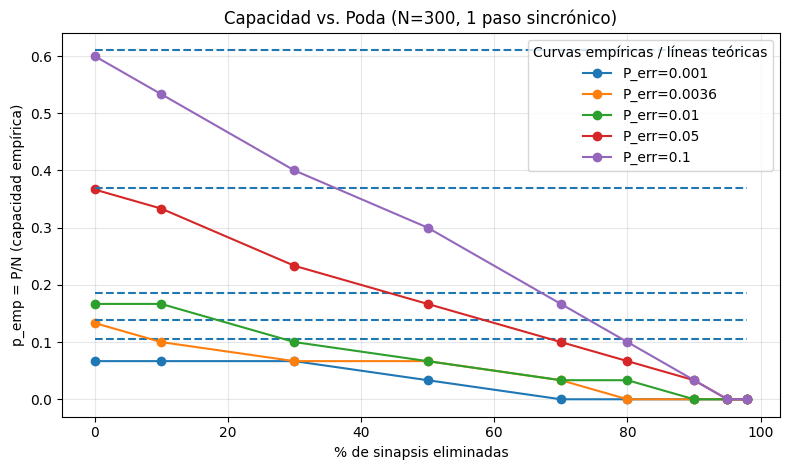


=== Capacidad vs Poda (N=600) ===
poda= 0%  ->  P_err=0.001: emp=0.100 | teo=0.105  |  P_err=0.0036: emp=0.133 | teo=0.138  |  P_err=0.01: emp=0.183 | teo=0.185  |  P_err=0.05: emp=0.367 | teo=0.370  |  P_err=0.1: emp=0.600 | teo=0.610
poda=10%  ->  P_err=0.001: emp=0.083 | teo=0.105  |  P_err=0.0036: emp=0.117 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.333 | teo=0.370  |  P_err=0.1: emp=0.550 | teo=0.610
poda=30%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.083 | teo=0.138  |  P_err=0.01: emp=0.117 | teo=0.185  |  P_err=0.05: emp=0.250 | teo=0.370  |  P_err=0.1: emp=0.417 | teo=0.610
poda=50%  ->  P_err=0.001: emp=0.050 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.083 | teo=0.185  |  P_err=0.05: emp=0.183 | teo=0.370  |  P_err=0.1: emp=0.300 | teo=0.610
poda=70%  ->  P_err=0.001: emp=0.033 | teo=0.105  |  P_err=0.0036: emp=0.033 | teo=0.138  |  P_err=0.01: emp=0.050 | teo=0.185  |  P_err=0.05: emp=0.100 | te

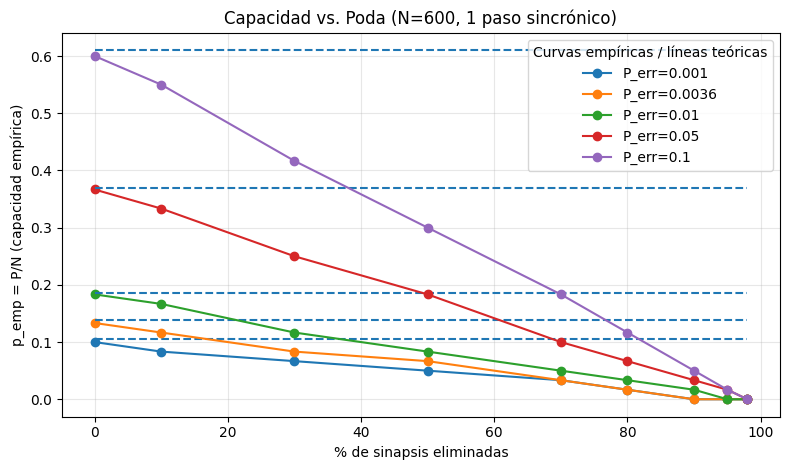


=== Capacidad vs Poda (N=900) ===
poda= 0%  ->  P_err=0.001: emp=0.100 | teo=0.105  |  P_err=0.0036: emp=0.133 | teo=0.138  |  P_err=0.01: emp=0.178 | teo=0.185  |  P_err=0.05: emp=0.367 | teo=0.370  |  P_err=0.1: emp=0.600 | teo=0.610
poda=10%  ->  P_err=0.001: emp=0.089 | teo=0.105  |  P_err=0.0036: emp=0.122 | teo=0.138  |  P_err=0.01: emp=0.167 | teo=0.185  |  P_err=0.05: emp=0.333 | teo=0.370  |  P_err=0.1: emp=0.544 | teo=0.610
poda=30%  ->  P_err=0.001: emp=0.067 | teo=0.105  |  P_err=0.0036: emp=0.089 | teo=0.138  |  P_err=0.01: emp=0.122 | teo=0.185  |  P_err=0.05: emp=0.256 | teo=0.370  |  P_err=0.1: emp=0.422 | teo=0.610
poda=50%  ->  P_err=0.001: emp=0.044 | teo=0.105  |  P_err=0.0036: emp=0.067 | teo=0.138  |  P_err=0.01: emp=0.089 | teo=0.185  |  P_err=0.05: emp=0.178 | teo=0.370  |  P_err=0.1: emp=0.300 | teo=0.610
poda=70%  ->  P_err=0.001: emp=0.022 | teo=0.105  |  P_err=0.0036: emp=0.033 | teo=0.138  |  P_err=0.01: emp=0.056 | teo=0.185  |  P_err=0.05: emp=0.111 | te

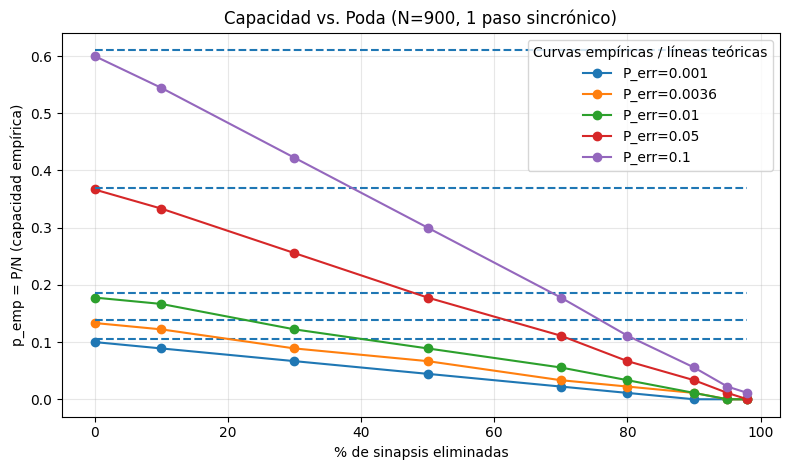

In [27]:
def experimento_simple_podado(
    N, P_values, podas, trials=3,
    targets=(0.001, 0.0036, 0.01, 0.05, 0.1),
    norm='N',
    patrones_source=None,
    seed_base=1234
):
   
    def _to_pm1(X):
        X = np.asarray(X)
        U = set(np.unique(X).tolist())
        if U.issubset({0, 1}):
            X = (X.astype(np.int8) * 2 - 1)
        elif not U.issubset({-1, 1}):
            X = np.where(X > 0, 1, -1).astype(np.int8)
        return X.astype(np.int8, copy=False)

    def _get_patrones(N, P, trial, seed):
        if callable(patrones_source):
            X0 = patrones_source(N, P, trial)
        elif isinstance(patrones_source, dict):
            pool = patrones_source.get(P, None)
            if pool is None:
                raise KeyError(f"No hay patrones para P={P} en patrones_source.")
            X0 = pool[trial % len(pool)] if isinstance(pool, (list, tuple)) else pool
        else:
            X0 = generar_patrones_aleatorios(
                N, P, seed=seed, valores='pm1', return_type='ndarray', dtype=np.int8
            )
        X0 = _to_pm1(X0)
        if X0.shape != (P, N):
            raise ValueError(f"Shape esperado ({P},{N}) y obtuve {X0.shape} para P={P}.")
        return X0

    resultados_por_poda = {}

    for poda in podas:
        mean_errors = []
        for P in P_values:
            errs = []
            for t in range(trials):
                seed = seed_base + 1000 * P + 10_000 * int(poda*1000) + t
                X0 = _get_patrones(N, P, trial=t, seed=seed)
                W  = entrenar_red_hopfield(X0, norm=norm)
                Wp = podar_sinapsis_simple(W, poda, seed=seed+7)  
                X_new = signo_binario(X0 @ Wp)                    
                errores_bits = np.count_nonzero(X_new != X0)
                errs.append(errores_bits / (P * N))
            mean_errors.append(float(np.mean(errs)))

    
        out = []
        for target in targets:
            last_ok = None
            for P, err in zip(P_values, mean_errors):
                if err <= target:
                    last_ok = (P, err)
            if last_ok:
                P_ok, err_ok = last_ok
                out.append((target, P_ok / N, err_ok))
            else:
                out.append((target, None, None))
        resultados_por_poda[poda] = out

    return resultados_por_poda

def plot_cap_vs_poda(N, resultados_por_poda, theoretical):
    """
    Un gr√°fico por N: l√≠neas de p_emp (y) vs poda (x) para cada P_error target.
    L√≠nea horizontal = p_teo (sin poda) para referencia.
    """
    podas = sorted(resultados_por_poda.keys())
    targets = [t for (t, _, _) in resultados_por_poda[podas[0]]]

    plt.figure(figsize=(8, 4.8))
    for t in targets:
        y = []
        for p in podas:
            triplets = resultados_por_poda[p]
            for (tt, p_emp, _) in triplets:
                if tt == t:
                    y.append(0.0 if p_emp is None else p_emp)
                    break
        plt.plot([int(100*p) for p in podas], y, marker='o', label=f"P_err={t:.4g}")
        plt.hlines(theoretical[t], xmin=int(100*podas[0]), xmax=int(100*podas[-1]), linestyles='dashed')

    plt.xlabel('% de sinapsis eliminadas')
    plt.ylabel('p_emp = P/N (capacidad emp√≠rica)')
    plt.title(f"Capacidad vs. Poda (N={N}, 1 paso sincr√≥nico)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Curvas emp√≠ricas / l√≠neas te√≥ricas")
    plt.tight_layout()
    plt.show()

THEORETICAL = { 
    0.001: 0.105,
    0.0036: 0.138,
    0.01: 0.185,
    0.05: 0.37,
    0.1: 0.61,
}

P_range = {
    300:  list(range(10, 500, 10)),
    600:  list(range(10, 800, 10)),
    900:  list(range(10, 1000, 10)),
}
Ns = list(P_range.keys())


PODAS = [0.0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.98]

for N in Ns:
    res_podado = experimento_simple_podado(
        N=N,
        P_values=P_range[N],
        podas=PODAS,
        trials=3,
        targets=tuple(THEORETICAL.keys()),
        norm='N',
        patrones_source=None,  
        seed_base=1234
    )

    print(f"\n=== Capacidad vs Poda (N={N}) ===")
    for poda in PODAS:
        triples = res_podado[poda]
        cols = []
        for t, p_emp, err in triples:
            p_teo = THEORETICAL[t]
            if p_emp is None:
                cols.append(f"P_err={t:.4g}: emp=--  | teo={p_teo:.3f}")
            else:
                cols.append(f"P_err={t:.4g}: emp={p_emp:.3f} | teo={p_teo:.3f}")
        print(f"poda={int(100*poda):>2d}%  ->  " + "  |  ".join(cols))

    plot_cap_vs_poda(N, res_podado, THEORETICAL)


## Conclusiones: capacidad vs. poda de sinapsis (N = 300, 600, 900)

**Qu√© comparamos:** capacidad emp√≠rica $p_{\text{emp}} = P/N$ (1 paso sincr√≥nico) para distintos umbrales de error $P_{\text{error}}$ y niveles de poda ($0\text{‚Äì}98\%$), frente a la **teor√≠a sin poda**.

### Sin poda (0%)
- Los valores emp√≠ricos est√°n **muy cerca** de la teor√≠a, especialmente para $N=600$ y $N=900$.
- Para $N=300$, hay una ligera subestimaci√≥n en el umbral m√°s estricto ($P_{\text{error}}=0.001$).

### Efecto de la poda (tendencia general)
- La capacidad **disminuye aproximadamente de manera lineal** a medida que aumenta el porcentaje de sinapsis eliminadas hasta cierto punto.
- Los umbrales de error m√°s estrictos ($0.001$, $0.0036$) **pierden capacidad antes** que los m√°s relajados ($0.05$, $0.1$).
- A partir de **$70\text{‚Äì}80\%$** de poda, la ca√≠da se vuelve **m√°s pronunciada** y se acerca al colapso total.

### Comparaci√≥n por tama√±o de red (robustez)
- **Redes m√°s grandes son m√°s tolerantes**: a igual porcentaje de poda, $N=900$ conserva m√°s capacidad que $N=600$, y ambos m√°s que $N=300$.
  - A **$90\%$** de poda y $P_{\text{error}}=0.1$:
    - $N=300$: $p_{\text{emp}}\approx 0.033$
    - $N=600$: $p_{\text{emp}}\approx 0.050$
    - $N=900$: $p_{\text{emp}}\approx 0.056$
  - A **$95\%$** de poda y $P_{\text{error}}=0.1$:
    - $N=300$: sin capacidad
    - $N=600$: $p_{\text{emp}}\approx 0.017$
    - $N=900$: $p_{\text{emp}}\approx 0.022$
  - A **$98\%$** de poda y $P_{\text{error}}=0.1$:
    - $N=300,600$: sin capacidad
    - $N=900$: $p_{\text{emp}}\approx 0.011$

### Conclusi√≥n
- Con **poda moderada** ($\le 50\%$), la red mantiene una fracci√≥n significativa de su capacidad, especialmente para umbrales m√°s relajados.
- Para **poda alta** ($\ge 70\%$), la capacidad **cae casi linealmente** antes de desplomarse al acercarse al colapso total, y los **umbrales estrictos desaparecen primero**.
- En resumen: la poda reduce la capacidad, pero **redes m√°s grandes son m√°s tolerantes**, y la relaci√≥n lineal parcial entre capacidad y % de sinapsis eliminadas se observa claramente antes del colapso.
